# Predcition of Hospital Admission Related to Cough

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to cough.

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'cough_date_'+str(i), 'cough_ab_date_'+str(i), 'cough_ab_type_'+str(i),
                   'incdt_cough_date_'+str(i), 'admitted_cough_date_'+str(i), 'sgss_gp_cov_cough_date_'+str(i)]]
    
    #drop rows with no cough reord
    datum = datum[datum['cough_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with cough_i
    datum = datum[datum['sgss_gp_cov_cough_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'cough_date_'+str(i): 'cough_date', 'cough_ab_date_'+str(i): 'cough_ab_date', 
                           'cough_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_cough_date_'+str(i): 'incdt_cough_date', 'incdt_cough_type_'+str(i): 'incdt_cough_type',
                           'admitted_cough_date_'+str(i): 'admitted_cough_date',
                           'sgss_gp_cov_cough_date_'+str(i): 'sgss_gp_cov_cough_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [8]:
#build cox models
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [9]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [10]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [13]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [14]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [18]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough.csv.gz')

In [19]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [20]:
#process 20 coughs and concatenate them 
data_cough_1 = proc_infec_data(data,1)
data_cough_2 = proc_infec_data(data,2)
data_cough_3 = proc_infec_data(data,3)
data_cough_4 = proc_infec_data(data,4)
data_cough_5 = proc_infec_data(data,5)
data_cough_6 = proc_infec_data(data,6)
data_cough_7 = proc_infec_data(data,7)
data_cough_8 = proc_infec_data(data,8)
data_cough_9 = proc_infec_data(data,9)
data_cough_10 = proc_infec_data(data,10)
data_cough_11 = proc_infec_data(data,11)
data_cough_12 = proc_infec_data(data,12)
data_cough_13 = proc_infec_data(data,13)
data_cough_14 = proc_infec_data(data,14)
data_cough_15 = proc_infec_data(data,15)
data_cough_16 = proc_infec_data(data,16)
data_cough_17 = proc_infec_data(data,17)
data_cough_18 = proc_infec_data(data,18)
data_cough_19 = proc_infec_data(data,19)
data_cough_20 = proc_infec_data(data,20)

data_cough = pd.concat([data_cough_1, data_cough_2, data_cough_3, data_cough_4, data_cough_5, data_cough_6, data_cough_7, data_cough_8, data_cough_9, data_cough_10, data_cough_11, data_cough_12, data_cough_13, data_cough_14, data_cough_15, data_cough_16, data_cough_17, data_cough_18, data_cough_19, data_cough_20])
data_cough.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [21]:
##add variable season
#convert data types
data_cough['cough_date'] = data_cough['cough_date'].astype('datetime64[ns]')
data_cough['admitted_cough_date'] = data_cough['admitted_cough_date'].astype('datetime64[ns]')
data_cough.died_date = data_cough.died_date.astype('datetime64[ns]')
data_cough.deregistered_date = data_cough.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_cough['date'] = data_cough['cough_date'] 
data_cough['date'] = data_cough['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_cough with today's date in year and month
data_cough = data_cough[data_cough['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_cough = data_cough[data_cough['date'] != last_1_month_date_y_m]
data_cough = data_cough[data_cough['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of cough records
data_cough['season'] = np.nan
data_cough['date_month'] = pd.DatetimeIndex(data_cough['date']).month

conditions = [
    (data_cough['date_month'] >= 3) & (data_cough['date_month'] <= 5),
    (data_cough['date_month'] >= 6) & (data_cough['date_month'] <= 8),
    (data_cough['date_month'] >= 9) & (data_cough['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_cough['season'] = np.select(conditions, choices, default='winter')

In [22]:
#add variable time period
data_cough.loc[(data_cough['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_cough.loc[((data_cough['date'] >= '2020-01') & (data_cough['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_cough.loc[(data_cough['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [23]:
#scenario 1
#not hosped (nothing happened)
data_cough.loc[data_cough['admitted_cough_date'].isnull(), 'event_cough_admitted'] = 0

In [24]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_cough['delta_cough_admitted'] = (data_cough['admitted_cough_date'] - data_cough['cough_date']).dt.days
data_cough.loc[((data_cough['delta_cough_admitted'] >= 0) & (data_cough['delta_cough_admitted'] <= 30)), 'event_cough_admitted'] = 1

#scenario 2
#drop whoever was admitted before cough consultation, i.e. negative value for delta_cough_admitted
data_cough = data_cough[~(data_cough['delta_cough_admitted'] < 0)]

In [25]:
#scenario 3
#censor died patients
data_cough['delta_admitted_died'] = (data_cough['died_date'] - data_cough['admitted_cough_date']).dt.days
data_cough.loc[data_cough['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_cough.loc[((data_cough['delta_admitted_died'] >= 0) & (data_cough['delta_admitted_died'] <= 30)), 'event_cough_admitted'] = 0

#scenario 3
#censor deregistered patients
data_cough['delta_admitted_deregistered'] = (data_cough['deregistered_date'] - data_cough['admitted_cough_date']).dt.days
data_cough.loc[data_cough['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_cough.loc[((data_cough['delta_admitted_deregistered'] > 0) & (data_cough['delta_admitted_deregistered'] <= 30)), 'event_cough_admitted'] = 0

#agg scenario 3s
data_cough['delta_admitted_died_deregistered'] = data_cough['delta_admitted_deregistered'].combine_first(data_cough['delta_admitted_died'])
data_cough.loc[data_cough['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [26]:
#scenario 1
#any other patients (nothing happened)
data_cough['event_cough_admitted'] = data_cough['event_cough_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_cough['duration_cough_admitted'] = data_cough['delta_cough_admitted'].combine_first(data_cough['delta_admitted_died_deregistered'])
data_cough['duration_cough_admitted'] = data_cough['duration_cough_admitted'].replace(np.NaN, 30)
data_cough.loc[(data_cough['duration_cough_admitted'] > 30), 'duration_cough_admitted'] = 30

#give value 1 to event_cough_admitted if duration_cough_admitted is greater or equal to 0 and less than 30
data_cough.loc[((data_cough['duration_cough_admitted'] >= 0) & (data_cough['duration_cough_admitted'] < 30)), 'event_cough_admitted'] = 1

#drop any rows with value 0 in duration column
data_cough = data_cough[~(data_cough['duration_cough_admitted'] == 0)]

In [27]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_cough.loc[((data_cough['delta_cough_admitted'] > 0) & (data_cough['delta_cough_admitted'] < 30)), 'event_cough_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [28]:
#drop anybody with age less than 18 or 0!
data_cough = data_cough[~(data_cough['age'] < 18)] 
data_cough['age'][data_cough['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_cough = data_cough[data_cough['age_cat'] != '0-4']
data_cough = data_cough[data_cough['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_cough['bmi'][data_cough['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_cough['bmi'] = data_cough['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_cough['antibacterial_brit'][data_cough['antibacterial_brit'] < 0] = np.nan

In [29]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_cough = data_cough.replace({"sex": dict_sex})
data_cough = data_cough.replace({"smoking_status": dict_smoking})

In [30]:
#drop rows with missing region
if ('region' in data_cough.columns) and (data_cough['region'].isnull().sum() > 0):
   data_cough = data_cough[data_cough['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_cough.columns) and (data_cough['antibacterial_brit'].isnull().sum() > 0):
    data_cough['antibacterial_brit'] = data_cough['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_cough.columns) and (data_cough['ethnicity'].isnull().sum() > 0):
    data_cough['ethnicity'] = data_cough['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_cough.columns) and (data_cough['smoking_status'].isnull().sum() > 0):
    data_cough['smoking_status'] = data_cough['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_cough.columns) and (data_cough['imd'].isnull().sum() > 0):
    data_cough['imd'] = data_cough['imd'].fillna(0)

In [31]:
#missing values of bmi assign 5 and 0; categorise bmi
data_cough['bmi_cat'] = 5

for idx, x in enumerate(data_cough['bmi_cat']):
    if data_cough.iat[idx, data_cough.columns.get_loc('bmi')] >= 30:
        data_cough.iat[idx, data_cough.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_cough.iat[idx, data_cough.columns.get_loc('bmi')] >= 25) and (data_cough.iat[idx, data_cough.columns.get_loc('bmi')] < 30):
        data_cough.iat[idx, data_cough.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_cough.iat[idx, data_cough.columns.get_loc('bmi')] >= 18.5) and (data_cough.iat[idx, data_cough.columns.get_loc('bmi')] < 25):
        data_cough.iat[idx, data_cough.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_cough.iat[idx, data_cough.columns.get_loc('bmi')] < 18.5:
        data_cough.iat[idx, data_cough.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_cough.columns) and (data_cough['bmi_cat'].isnull().sum() > 0):
    data_cough['bmi_cat'] = data_cough['bmi_cat'].fillna(0)

In [32]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_cough.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_cough['ab_type_cat'] = np.where(data_cough['ab_type'].isin(ab_series[mask].index),'other',data_cough['ab_type'])
#assign no to non ab users
data_cough.loc[data_cough['cough_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_cough['ab_type_cat'] = data_cough['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [33]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_cough = data_cough.replace({"sex": dict_sex})
data_cough = data_cough.replace({"ethnicity": dict_ethnicity})
data_cough = data_cough.replace({"smoking_status": dict_smoking})
data_cough = data_cough.replace({"imd": dict_imd})
data_cough = data_cough.replace({"bmi_cat": dict_bmi})
data_cough = data_cough.replace({"flu_vaccine": dict_flu})
data_cough = data_cough.replace({"region": dict_region})
data_cough = data_cough.replace({"age_cat": dict_age})
data_cough = data_cough.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [34]:
#categorise CCI
data_cough['CCI_cat'] = pd.cut(data_cough['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_cough['antibacterial_brit'].clip(0, data_cough['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

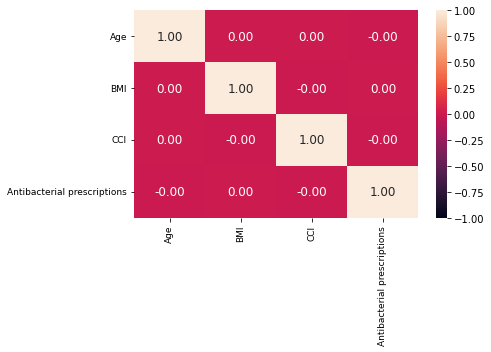

In [35]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_cough[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_cough/corr_cough.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [36]:
data_cough = data_cough[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'cough_ab_date', 'ab_type_cat', 'incdt_cough_date', 'date', 'period',
                                   'event_cough_admitted', 'duration_cough_admitted'
                                    ]]

In [37]:
#incident and prevalent infection 
data_cough_incdt = data_cough[data_cough['incdt_cough_date'] == 0]
data_cough_prevl = data_cough[data_cough['incdt_cough_date'] == 1]
#switch variable cough_ab_date into a binary variable
data_cough_incdt[['cough_ab_date']] = data_cough_incdt[['cough_ab_date']].where(data_cough_incdt[['cough_ab_date']].isnull(), 1).fillna(0).astype(int)
data_cough_prevl[['cough_ab_date']] = data_cough_prevl[['cough_ab_date']].where(data_cough_prevl[['cough_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_cough_incdt_males = data_cough_incdt[data_cough_incdt['sex'] == 'male']
data_cough_incdt_females = data_cough_incdt[data_cough_incdt['sex'] == 'female']
data_cough_prevl_males = data_cough_prevl[data_cough_prevl['sex'] == 'male']
data_cough_prevl_females = data_cough_prevl[data_cough_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_cough_incdt_15_24 = data_cough_incdt[data_cough_incdt['age_cat'] == '15_24']
data_cough_incdt_25_34 = data_cough_incdt[data_cough_incdt['age_cat'] == '25_34']
data_cough_incdt_35_44 = data_cough_incdt[data_cough_incdt['age_cat'] == '35_44']
data_cough_incdt_45_54 = data_cough_incdt[data_cough_incdt['age_cat'] == '45_54']
data_cough_incdt_55_64 = data_cough_incdt[data_cough_incdt['age_cat'] == '55_64']
data_cough_incdt_65_74 = data_cough_incdt[data_cough_incdt['age_cat'] == '65_74']
data_cough_incdt_75_more = data_cough_incdt[data_cough_incdt['age_cat'] == '75_more']
data_cough_prevl_15_24 = data_cough_prevl[data_cough_prevl['age_cat'] == '15_24']
data_cough_prevl_25_34 = data_cough_prevl[data_cough_prevl['age_cat'] == '25_34']
data_cough_prevl_35_44 = data_cough_prevl[data_cough_prevl['age_cat'] == '35_44']
data_cough_prevl_45_54 = data_cough_prevl[data_cough_prevl['age_cat'] == '45_54']
data_cough_prevl_55_64 = data_cough_prevl[data_cough_prevl['age_cat'] == '55_64']
data_cough_prevl_65_74 = data_cough_prevl[data_cough_prevl['age_cat'] == '65_74']
data_cough_prevl_75_more = data_cough_prevl[data_cough_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_cough_incdt_prepandemic = data_cough_incdt[data_cough_incdt['date'] <= '2019-12']
data_cough_incdt_during_pandemic = data_cough_incdt[(data_cough_incdt['date'] >= '2020-03') & (data_cough_incdt['date']<= '2021-03')]
data_cough_incdt_post_2nd_lockdown = data_cough_incdt[data_cough_incdt['date'] <= '2021-04']
data_cough_prevl_prepandemic = data_cough_prevl[data_cough_prevl['date'] <= '2019-12']
data_cough_prevl_during_pandemic = data_cough_prevl[(data_cough_prevl['date'] >= '2020-03') & (data_cough_prevl['date']<= '2021-03')]
data_cough_prevl_post_2nd_lockdown = data_cough_prevl[data_cough_prevl['date'] <= '2021-04']

# no antibiotics and incident hospital admission
data_cough_no_abs_incdt = data_cough[data_cough['cough_ab_date'].isnull()]
data_cough_no_abs_incdt = data_cough_no_abs_incdt[data_cough_no_abs_incdt['incdt_cough_date'] == 0]

# with antibiotics and incident hospital admission
data_cough_abs_incdt = data_cough[data_cough['cough_ab_date'].notnull()]
data_cough_abs_incdt = data_cough_abs_incdt[data_cough_abs_incdt['incdt_cough_date'] == 0]

# no antibiotics and prevalent hospital admission
data_cough_no_abs_prevl = data_cough[data_cough['cough_ab_date'].isnull()]
data_cough_no_abs_prevl = data_cough_no_abs_prevl[data_cough_no_abs_prevl['incdt_cough_date'] == 1]

# with antibiotics and prevalent hospital admission
data_cough_abs_prevl = data_cough[data_cough['cough_ab_date'].notnull()]
data_cough_abs_prevl = data_cough_abs_prevl[data_cough_abs_prevl['incdt_cough_date'] == 1]

In [38]:
#store data for plotting hosp admission counts and percentages
%store data_cough
# save data
data_cough.to_csv('../output/hospitalisation_prediction_cough/data_cough.csv')

Stored 'data_cough' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident cough with no antibiotics

<lifelines.CoxPHFitter: fitted with 112569 total observations, 111741 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 112569
number of events observed = 828
   partial log-likelihood = -9612.60
         time fit was run = 2023-02-02 11:09:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.24       1.28       0.11             0.03             0.46                 1.03                 1.58
CCI_cat[T.medium]                0.17       1.18       0.12            -0.07             0.40                 0.93                 1.50
CCI_cat[T.high]                  0.28       1.33       0.14             0.01             0.56                 1.01                 1.74
CCI_cat[T.very_high]             0.24       1.27       0.13            -0.01             0.48                 0.99                 1.62
age_cat[T.25_34]                 0.09       1.10       0.13            -0.16             0.35                 0.85                 1.42
age_cat[T.35_44]                -0.08       0.92       0.14            -0.35             0.19                 0.70                 1.21
age_cat[T.45_54]                 0.05       1.05       0.13            -0.21             0.31                 0.81                 1.36
age_cat[T.55_64]                 0.10       1.11       0.13            -0.15             0.36                 0.86                 1.43
age_cat[T.65_74]                 0.23       1.26       0.13            -0.02             0.48                 0.98                 1.61
age_cat[T.75_more]               0.07       1.07       0.13            -0.19             0.33                 0.82                 1.38
antibacterial_brit               0.03       1.03       0.02            -0.01             0.08                 0.99                 1.08
bmi_cat[T.obese]                 0.03       1.03       0.13            -0.23             0.28                 0.79                 1.33
bmi_cat[T.overweight]           -0.06       0.94       0.16            -0.38             0.26                 0.69                 1.30
bmi_cat[T.underweight]           0.10       1.11       0.22            -0.33             0.54                 0.72                 1.71
bmi_cat[T.unknown]               0.05       1.05       0.14            -0.23             0.32                 0.80                 1.38
ethnicity[T.unknown]            -0.09       0.91       0.11            -0.31             0.13                 0.73                 1.13
ethnicity[T.white]              -0.10       0.91       0.10            -0.29             0.10                 0.75                 1.10
flu_vaccine[T.yes]              -0.01       0.99       0.12            -0.23             0.22                 0.79                 1.25
imd[T.medium]                   -0.19       0.83       0.11            -0.41             0.03                 0.66                 1.03
imd[T.unaffluent]               -0.10       0.91       0.11            -0.31             0.12                 0.73                 1.13
imd[T.unknown]                   0.11       1.12       0.16            -0.20             0.42                 0.82                 1.53
imd[T.very_affluent]            -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.18
imd[T.very_unaffluent]          -0.20       0.82       0.11            -0.42             0.03                 0.66                 1.03
region[T.east_midlands]         -0.09       0.91       0.15            -0.39             0.21                 0.68                 1.23
region[T.london]                -0.15       0.86       0.13    

11967


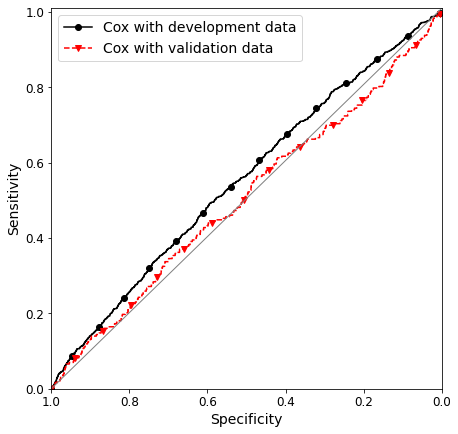

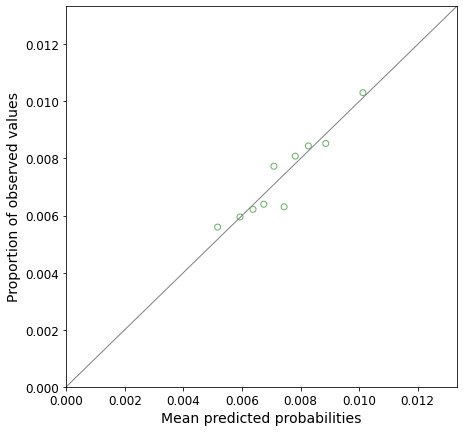

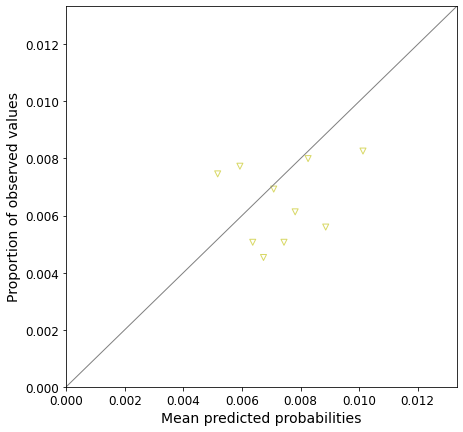

In [39]:
#data prep
data, data_cough_no_abs_incdt_enc = cox_data_prep(data_cough_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

#make summary table
make_summary_table('cough', 'no_abs_incdt', data_cough_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('cough', 'no_abs_incdt', data_cough_no_abs_incdt)

try:
    #build cox model 
    cph_cough_no_abs_incdt, data_cough_no_abs_incdt_train, data_cough_no_abs_incdt_test = cox_model_build('cough', 'no_abs_incdt', data_cough_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_cough_no_abs_incdt, '../output/hospitalisation_prediction_cough/', 'betas_cph_cough_no_abs_incdt.csv', data_cough_no_abs_incdt_enc, data_cough_no_abs_incdt, 'sum_betas_cph_cough_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_cough_no_abs_incdt, 'event_cough_admitted', data_cough_no_abs_incdt_train, data_cough_no_abs_incdt_test, '../output/hospitalisation_prediction_cough', 'roc_cph_cough_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_cough_no_abs_incdt, data_cough_no_abs_incdt_train, 'event_cough_admitted', data_cough_no_abs_incdt_test, '../output/hospitalisation_prediction_cough/', 'calibration_cph_cough_no_abs_incdt_train.jpg', 'calibration_cph_cough_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_cough_no_abs_incdt, 'cough', 'no_abs_incdt', data_cough_no_abs_incdt_train, data_cough_no_abs_incdt_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident cough with antibiotics

<lifelines.CoxPHFitter: fitted with 12528 total observations, 12433 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 12528
number of events observed = 95
   partial log-likelihood = -876.13
         time fit was run = 2023-02-02 11:09:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.13       1.14       0.30            -0.45             0.72                 0.64                 2.06
CCI_cat[T.medium]               -0.12       0.89       0.35            -0.80             0.57                 0.45                 1.76
CCI_cat[T.high]                  0.23       1.25       0.37            -0.51             0.96                 0.60                 2.61
CCI_cat[T.very_high]            -0.26       0.77       0.38            -1.00             0.49                 0.37                 1.64
age_cat[T.25_34]                -0.52       0.60       0.44            -1.39             0.35                 0.25                 1.42
age_cat[T.35_44]                -0.29       0.75       0.40            -1.08             0.50                 0.34                 1.65
age_cat[T.45_54]                -0.43       0.65       0.43            -1.27             0.41                 0.28                 1.51
age_cat[T.55_64]                 0.46       1.58       0.34            -0.21             1.13                 0.81                 3.10
age_cat[T.65_74]                -0.32       0.73       0.41            -1.13             0.50                 0.32                 1.64
age_cat[T.75_more]               0.44       1.55       0.35            -0.24             1.12                 0.79                 3.05
antibacterial_brit              -0.08       0.92       0.08            -0.23             0.06                 0.79                 1.06
bmi_cat[T.obese]                -0.39       0.68       0.32            -1.02             0.24                 0.36                 1.27
bmi_cat[T.overweight]           -0.59       0.55       0.44            -1.46             0.27                 0.23                 1.31
bmi_cat[T.underweight]          -1.63       0.20       1.04            -3.67             0.41                 0.03                 1.51
bmi_cat[T.unknown]              -0.59       0.55       0.36            -1.30             0.12                 0.27                 1.13
ethnicity[T.unknown]             0.21       1.23       0.35            -0.48             0.90                 0.62                 2.45
ethnicity[T.white]               0.17       1.19       0.32            -0.45             0.80                 0.64                 2.22
flu_vaccine[T.yes]               0.51       1.67       0.28            -0.04             1.07                 0.96                 2.91
imd[T.medium]                    0.06       1.06       0.31            -0.55             0.67                 0.58                 1.96
imd[T.unaffluent]               -0.12       0.88       0.33            -0.77             0.52                 0.46                 1.69
imd[T.unknown]                  -0.51       0.60       0.62            -1.72             0.71                 0.18                 2.03
imd[T.very_affluent]            -0.05       0.95       0.32            -0.68             0.58                 0.51                 1.78
imd[T.very_unaffluent]          -0.29       0.75       0.34            -0.96             0.38                 0.38                 1.46
region[T.east_midlands]         -0.13       0.88       0.43            -0.97             0.72                 0.38                 2.04
region[T.london]                -0.38       0.68       0.38         

11973


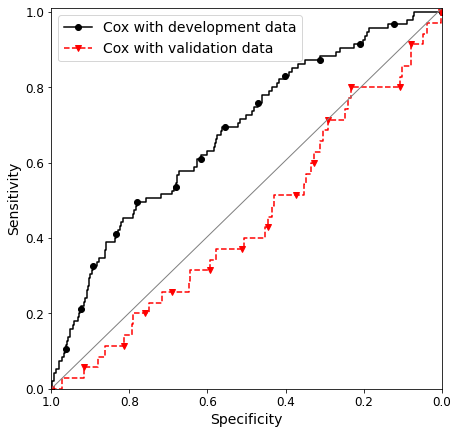

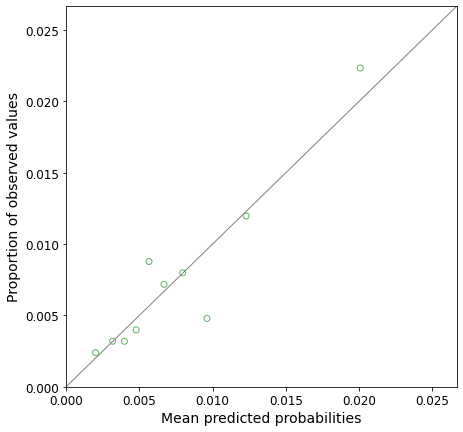

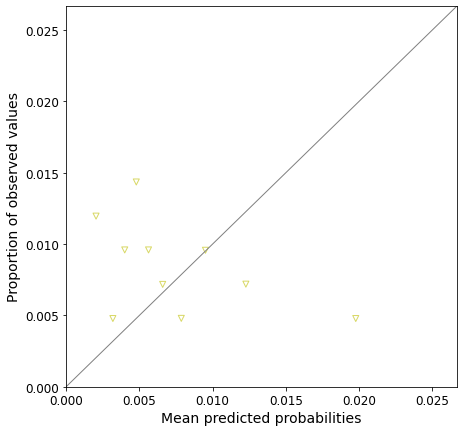

In [40]:
#data prep
data, data_cough_abs_incdt_enc = cox_data_prep(data_cough_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

#make summary table
make_summary_table('cough', 'abs_incdt', data_cough_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('cough', 'abs_incdt', data_cough_abs_incdt)

try:
    #build cox model 
    cph_cough_abs_incdt, data_cough_abs_incdt_train, data_cough_abs_incdt_test = cox_model_build('cough', 'abs_incdt', data_cough_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_cough_abs_incdt, '../output/hospitalisation_prediction_cough/', 'betas_cph_cough_abs_incdt.csv', data_cough_abs_incdt_enc, data_cough_abs_incdt, 'sum_betas_cph_cough_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_cough_abs_incdt, 'event_cough_admitted', data_cough_abs_incdt_train, data_cough_abs_incdt_test, '../output/hospitalisation_prediction_cough', 'roc_cph_cough_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_cough_abs_incdt, data_cough_abs_incdt_train, 'event_cough_admitted', data_cough_abs_incdt_test, '../output/hospitalisation_prediction_cough/', 'calibration_cph_cough_abs_incdt_train.jpg', 'calibration_cph_cough_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_cough_abs_incdt, 'cough', 'abs_incdt', data_cough_abs_incdt_train, data_cough_abs_incdt_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent cough with no antibiotics

<lifelines.CoxPHFitter: fitted with 12544 total observations, 12454 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 12544
number of events observed = 90
   partial log-likelihood = -835.13
         time fit was run = 2023-02-02 11:10:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.32            -0.69             0.56                 0.50                 1.76
CCI_cat[T.medium]                0.07       1.07       0.34            -0.60             0.74                 0.55                 2.10
CCI_cat[T.high]                  0.11       1.12       0.41            -0.69             0.91                 0.50                 2.49
CCI_cat[T.very_high]             0.19       1.21       0.35            -0.51             0.88                 0.60                 2.42
age_cat[T.25_34]                 0.55       1.74       0.40            -0.22             1.33                 0.80                 3.77
age_cat[T.35_44]                 0.34       1.41       0.41            -0.47             1.16                 0.63                 3.18
age_cat[T.45_54]                 0.00       1.00       0.45            -0.88             0.88                 0.42                 2.41
age_cat[T.55_64]                -0.04       0.96       0.45            -0.92             0.83                 0.40                 2.30
age_cat[T.65_74]                 0.44       1.55       0.40            -0.35             1.23                 0.70                 3.43
age_cat[T.75_more]               0.21       1.24       0.43            -0.63             1.05                 0.53                 2.87
antibacterial_brit               0.01       1.01       0.07            -0.13             0.16                 0.87                 1.17
bmi_cat[T.obese]                -0.15       0.86       0.36            -0.86             0.57                 0.42                 1.76
bmi_cat[T.overweight]            0.15       1.16       0.43            -0.69             0.99                 0.50                 2.68
bmi_cat[T.underweight]          -0.07       0.93       0.67            -1.38             1.24                 0.25                 3.46
bmi_cat[T.unknown]              -0.48       0.62       0.41            -1.29             0.33                 0.27                 1.39
ethnicity[T.unknown]             0.18       1.19       0.34            -0.50             0.85                 0.61                 2.33
ethnicity[T.white]               0.02       1.02       0.31            -0.58             0.63                 0.56                 1.88
flu_vaccine[T.yes]              -0.46       0.63       0.42            -1.29             0.37                 0.27                 1.44
imd[T.medium]                   -0.13       0.88       0.29            -0.69             0.44                 0.50                 1.56
imd[T.unaffluent]               -0.66       0.52       0.33            -1.31            -0.00                 0.27                 1.00
imd[T.unknown]                  -0.52       0.59       0.54            -1.58             0.54                 0.21                 1.71
imd[T.very_affluent]            -0.69       0.50       0.34            -1.36            -0.02                 0.26                 0.98
imd[T.very_unaffluent]          -0.85       0.43       0.36            -1.56            -0.14                 0.21                 0.87
region[T.east_midlands]          0.22       1.25       0.47            -0.71             1.15                 0.49                 3.16
region[T.london]                 0.24       1.27       0.42         

11960


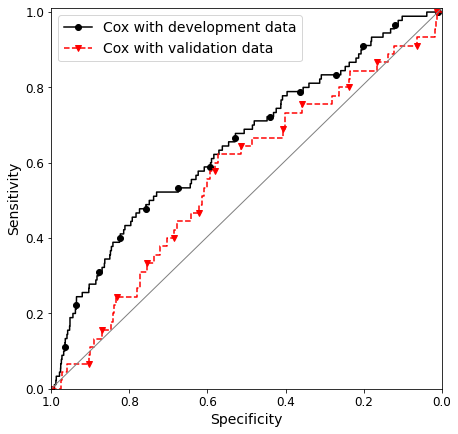

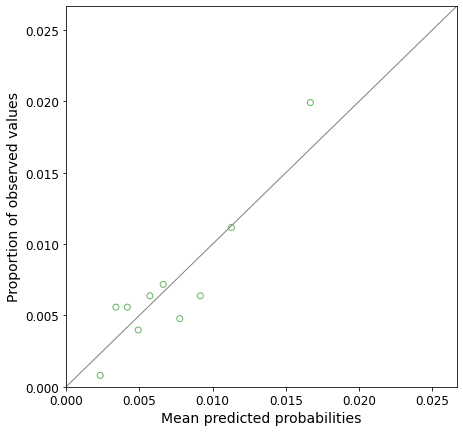

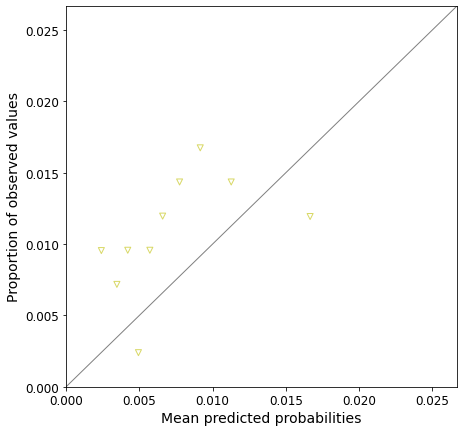

In [41]:
#data prep
data, data_cough_no_abs_prevl_enc = cox_data_prep(data_cough_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

#make summary table
make_summary_table('cough', 'no_abs_prevl', data_cough_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('cough', 'no_abs_prevl', data_cough_no_abs_prevl)

try:
    #build cox model 
    cph_cough_no_abs_prevl, data_cough_no_abs_prevl_train, data_cough_no_abs_prevl_test = cox_model_build('cough', 'no_abs_prevl', data_cough_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_cough_no_abs_prevl, '../output/hospitalisation_prediction_cough/', 'betas_cph_cough_no_abs_prevl.csv', data_cough_no_abs_prevl_enc, data_cough_no_abs_prevl, 'sum_betas_cph_cough_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_cough_no_abs_prevl, 'event_cough_admitted', data_cough_no_abs_prevl_train, data_cough_no_abs_prevl_test, '../output/hospitalisation_prediction_cough', 'roc_cph_cough_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_cough_no_abs_prevl, data_cough_no_abs_prevl_train, 'event_cough_admitted', data_cough_no_abs_prevl_test, '../output/hospitalisation_prediction_cough/', 'calibration_cph_cough_no_abs_prevl_train.jpg', 'calibration_cph_cough_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_cough_no_abs_prevl, 'cough', 'no_abs_prevl', data_cough_no_abs_prevl_train, data_cough_no_abs_prevl_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent cough with antibiotics

<lifelines.CoxPHFitter: fitted with 1343 total observations, 1335 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 1343
number of events observed = 8
   partial log-likelihood = -33.59
         time fit was run = 2023-02-02 11:10:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.65       1.92       1.36            -2.02             3.32                 0.13                27.77
CCI_cat[T.medium]              -18.43       0.00   11845.03        -23234.26         23197.40                 0.00                  inf
CCI_cat[T.high]                  0.84       2.33       1.74            -2.56             4.25                 0.08                70.06
CCI_cat[T.very_high]             2.21       9.11       1.39            -0.52             4.94                 0.59               139.73
age_cat[T.25_34]                 2.22       9.17       1.79            -1.29             5.72                 0.27               305.58
age_cat[T.35_44]                 2.78      16.05       1.74            -0.64             6.19                 0.53               489.09
age_cat[T.45_54]               -18.63       0.00   13967.25        -27393.94         27356.69                 0.00                  inf
age_cat[T.55_64]                 0.96       2.61       1.81            -2.59             4.51                 0.08                90.55
age_cat[T.65_74]                 1.30       3.67       1.94            -2.51             5.11                 0.08               165.15
age_cat[T.75_more]             -18.37       0.00   10981.26        -21541.23         21504.50                 0.00                  inf
antibacterial_brit              -0.49       0.61       0.46            -1.39             0.40                 0.25                 1.50
bmi_cat[T.obese]                 1.71       5.55       1.57            -1.36             4.79                 0.26               119.86
bmi_cat[T.overweight]          -17.96       0.00   10451.83        -20503.16         20467.25                 0.00                  inf
bmi_cat[T.underweight]         -17.91       0.00   19896.97        -39015.25         38979.42                 0.00                  inf
bmi_cat[T.unknown]               0.12       1.13       1.89            -3.58             3.83                 0.03                45.86
ethnicity[T.unknown]           -19.59       0.00    6956.71        -13654.49         13615.31                 0.00                  inf
ethnicity[T.white]              -0.87       0.42       1.24            -3.31             1.57                 0.04                 4.79
flu_vaccine[T.yes]              -0.52       0.59       1.27            -3.02             1.97                 0.05                 7.21
imd[T.medium]                    0.95       2.58       1.50            -2.00             3.89                 0.14                48.87
imd[T.unaffluent]                0.65       1.91       1.65            -2.59             3.89                 0.07                49.01
imd[T.unknown]                   1.03       2.79       1.74            -2.39             4.44                 0.09                84.86
imd[T.very_affluent]             0.85       2.33       1.49            -2.08             3.77                 0.13                43.28
imd[T.very_unaffluent]         -18.39       0.00    8841.77        -17347.94         17311.16                 0.00                  inf
region[T.east_midlands]          0.30       1.34       1.64            -2.91             3.50                 0.05                33.16
region[T.london]               -17.74       0.00    8389.68        -16461

12156


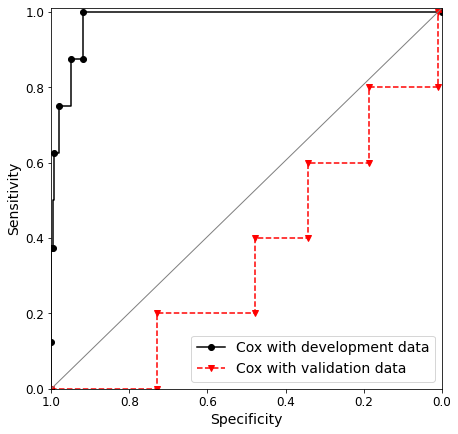

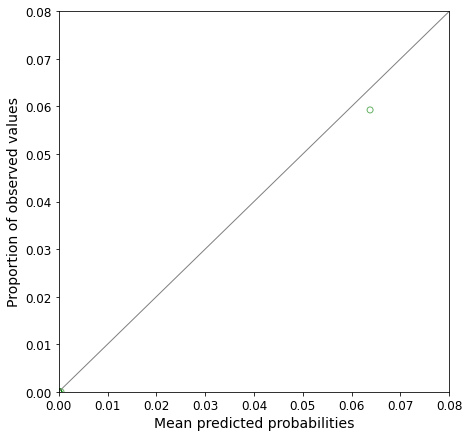

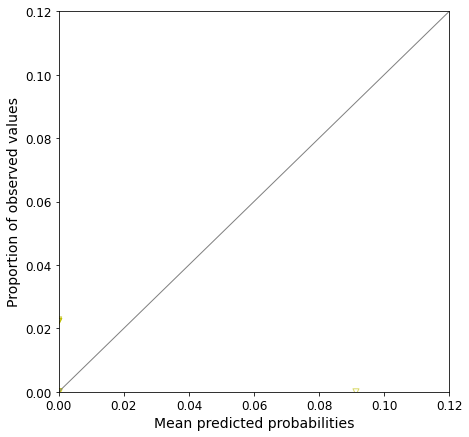

In [42]:
#data prep
data, data_cough_abs_prevl_enc = cox_data_prep(data_cough_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

#make summary table
make_summary_table('cough', 'abs_prevl', data_cough_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('cough', 'abs_prevl', data_cough_abs_prevl)

try:
    #build cox model 
    cph_cough_abs_prevl, data_cough_abs_prevl_train, data_cough_abs_prevl_test = cox_model_build('cough', 'abs_prevl', data_cough_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_cough_abs_prevl, '../output/hospitalisation_prediction_cough/', 'betas_cph_cough_abs_prevl.csv', data_cough_abs_prevl_enc, data_cough_abs_prevl, 'sum_betas_cph_cough_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_cough_abs_prevl, 'event_cough_admitted', data_cough_abs_prevl_train, data_cough_abs_prevl_test, '../output/hospitalisation_prediction_cough', 'roc_cph_cough_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_cough_abs_prevl, data_cough_abs_prevl_train, 'event_cough_admitted', data_cough_abs_prevl_test, '../output/hospitalisation_prediction_cough/', 'calibration_cph_cough_abs_prevl_train.jpg', 'calibration_cph_cough_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_cough_abs_prevl, 'cough', 'abs_prevl', data_cough_abs_prevl_train, data_cough_abs_prevl_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident cough

In [43]:
#data prep
data, data_cough_incdt_enc = cox_data_prep(data_cough_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

#make summary tables from preped data
make_summary_table('cough', 'incdt', data_cough_incdt_enc)
make_summary_table_hosped('cough', 'incdt', data_cough_incdt)

try:
    cph_cough_incdt, data_cough_incdt_train, data_cough_incdt_test = cox_model_abs_build('cough', 'incdt', data_cough_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_incdt, 'cough', 'incdt', data_cough_incdt_train, data_cough_incdt_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 125097 total observations, 124203 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 125097
number of events observed = 894
   partial log-likelihood = -10473.84
         time fit was run = 2023-02-02 11:10:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.17       1.18       0.10            -0.04             0.37                 0.96                 1.45
CCI_cat[T.medium]                0.23       1.25       0.11             0.00             0.45                 1.00                 1.57
CCI_cat[T.high]                  0.14       1.15       0.14            -0.13             0.41                 0.88                 1.50
CCI_cat[T.very_high]             0.18       1.20       0.12            -0.06             0.41                 0.95                 1.51
age_cat[T.25_34]                 0.05       1.05       0.12            -0.19             0.29                 0.83                 1.34
age_cat[T.35_44]                -0.15       0.86       0.13            -0.41             0.10                 0.66                 1.10
age_cat[T.45_54]                -0.13       0.88       0.13            -0.38             0.12                 0.68                 1.13
age_cat[T.55_64]                -0.04       0.96       0.13            -0.29             0.20                 0.75                 1.22
age_cat[T.65_74]                 0.12       1.13       0.12            -0.12             0.36                 0.89                 1.43
age_cat[T.75_more]               0.06       1.06       0.12            -0.18             0.30                 0.84                 1.35
antibacterial_brit               0.02       1.02       0.02            -0.03             0.06                 0.97                 1.07
bmi_cat[T.obese]                -0.09       0.92       0.12            -0.32             0.15                 0.72                 1.16
bmi_cat[T.overweight]           -0.17       0.84       0.15            -0.47             0.13                 0.62                 1.13
bmi_cat[T.underweight]          -0.24       0.78       0.23            -0.69             0.21                 0.50                 1.23
bmi_cat[T.unknown]              -0.05       0.95       0.13            -0.30             0.20                 0.74                 1.22
cough_ab_date                    0.10       1.10       0.11            -0.11             0.31                 0.90                 1.36
ethnicity[T.unknown]            -0.01       0.99       0.11            -0.22             0.21                 0.80                 1.23
ethnicity[T.white]               0.01       1.01       0.10            -0.18             0.20                 0.84                 1.22
flu_vaccine[T.yes]              -0.07       0.93       0.11            -0.29             0.15                 0.74                 1.17
imd[T.medium]                   -0.14       0.87       0.11            -0.35             0.07                 0.71                 1.08
imd[T.unaffluent]               -0.14       0.87       0.11            -0.36             0.07                 0.70                 1.07
imd[T.unknown]                   0.02       1.02       0.16            -0.29             0.33                 0.75                 1.40
imd[T.very_affluent]            -0.08       0.92       0.11            -0.29             0.13                 0.75                 1.14
imd[T.very_unaffluent]          -0.14       0.87       0.11            -0.35             0.07                 0.70                 1.07
region[T.east_midlands]         -0.19       0.82       0.14   

12227


### 5-6- hospital admission related to prevalent cough

In [44]:
#data prep
data, data_cough_prevl_enc = cox_data_prep(data_cough_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

#make summary tables from preped data
make_summary_table('cough', 'prevl', data_cough_prevl_enc)
make_summary_table_hosped('cough', 'prevl', data_cough_prevl)

try:
    cph_cough_prevl, data_cough_prevl_train, data_cough_prevl_test = cox_model_abs_build('cough', 'prevl', data_cough_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_prevl, 'cough', 'prevl', data_cough_prevl_train, data_cough_prevl_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13887 total observations, 13769 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 13887
number of events observed = 118
   partial log-likelihood = -1107.78
         time fit was run = 2023-02-02 11:10:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.10       0.28            -0.46             0.66                 0.63                 1.93
CCI_cat[T.medium]               -0.05       0.95       0.32            -0.68             0.57                 0.51                 1.77
CCI_cat[T.high]                  0.31       1.37       0.35            -0.37             1.00                 0.69                 2.72
CCI_cat[T.very_high]             0.29       1.34       0.32            -0.33             0.91                 0.72                 2.48
age_cat[T.25_34]                 0.52       1.68       0.34            -0.14             1.18                 0.87                 3.24
age_cat[T.35_44]                 0.37       1.44       0.35            -0.32             1.05                 0.73                 2.86
age_cat[T.45_54]                -0.19       0.83       0.39            -0.96             0.59                 0.38                 1.80
age_cat[T.55_64]                -0.04       0.97       0.38            -0.78             0.71                 0.46                 2.03
age_cat[T.65_74]                 0.27       1.31       0.35            -0.42             0.96                 0.66                 2.62
age_cat[T.75_more]               0.08       1.08       0.37            -0.65             0.81                 0.52                 2.24
antibacterial_brit              -0.01       0.99       0.06            -0.14             0.12                 0.87                 1.12
bmi_cat[T.obese]                -0.15       0.86       0.31            -0.77             0.47                 0.46                 1.60
bmi_cat[T.overweight]           -0.07       0.93       0.39            -0.83             0.69                 0.44                 2.00
bmi_cat[T.underweight]          -0.40       0.67       0.65            -1.67             0.87                 0.19                 2.38
bmi_cat[T.unknown]              -0.45       0.64       0.35            -1.14             0.24                 0.32                 1.28
cough_ab_date                   -0.01       0.99       0.32            -0.63             0.61                 0.53                 1.85
ethnicity[T.unknown]             0.09       1.09       0.32            -0.55             0.72                 0.58                 2.05
ethnicity[T.white]               0.23       1.26       0.28            -0.33             0.78                 0.72                 2.19
flu_vaccine[T.yes]              -0.18       0.84       0.33            -0.83             0.47                 0.44                 1.60
imd[T.medium]                   -0.02       0.99       0.26            -0.52             0.49                 0.59                 1.64
imd[T.unaffluent]               -0.51       0.60       0.29            -1.08             0.07                 0.34                 1.07
imd[T.unknown]                  -0.33       0.72       0.45            -1.20             0.55                 0.30                 1.74
imd[T.very_affluent]            -0.47       0.62       0.29            -1.05             0.10                 0.35                 1.11
imd[T.very_unaffluent]          -0.78       0.46       0.32            -1.42            -0.14                 0.24                 0.87
region[T.east_midlands]          0.13       1.14       0.44       

12223


### 5-7- hospital admission related to incident cough with prescribed antibiotics categories

In [45]:
#data prep
data, data_cough_incdt_abs_enc = cox_data_prep(data_cough_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_abs, data_cough_incdt_abs_train, data_cough_incdt_abs_test = cox_model_ab_type_build('cough', 'incdt_ab_type', data_cough_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_incdt_abs, 'cough', 'incdt_abs', data_cough_incdt_abs_train, data_cough_incdt_abs_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 125097 total observations, 124203 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 125097
number of events observed = 894
   partial log-likelihood = -10472.66
         time fit was run = 2023-02-02 11:10:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.17       1.18       0.10            -0.04             0.37                 0.96                 1.45
CCI_cat[T.medium]                0.23       1.25       0.11             0.00             0.45                 1.00                 1.57
CCI_cat[T.high]                  0.14       1.15       0.14            -0.13             0.41                 0.88                 1.50
CCI_cat[T.very_high]             0.18       1.20       0.12            -0.06             0.41                 0.95                 1.51
ab_type_cat[T.Doxycycline]       0.49       1.63       0.61            -0.71             1.69                 0.49                 5.42
ab_type_cat[T.no]               -0.35       0.71       0.36            -1.05             0.35                 0.35                 1.42
ab_type_cat[T.other]            -0.29       0.75       0.37            -1.02             0.43                 0.36                 1.54
age_cat[T.25_34]                 0.05       1.05       0.12            -0.19             0.29                 0.83                 1.34
age_cat[T.35_44]                -0.15       0.86       0.13            -0.41             0.10                 0.66                 1.10
age_cat[T.45_54]                -0.13       0.88       0.13            -0.38             0.12                 0.68                 1.13
age_cat[T.55_64]                -0.04       0.96       0.13            -0.29             0.20                 0.75                 1.22
age_cat[T.65_74]                 0.12       1.12       0.12            -0.12             0.35                 0.89                 1.43
age_cat[T.75_more]               0.06       1.06       0.12            -0.18             0.30                 0.83                 1.35
antibacterial_brit               0.02       1.02       0.02            -0.03             0.06                 0.97                 1.07
bmi_cat[T.obese]                -0.09       0.92       0.12            -0.32             0.15                 0.72                 1.16
bmi_cat[T.overweight]           -0.17       0.84       0.15            -0.47             0.12                 0.62                 1.13
bmi_cat[T.underweight]          -0.24       0.78       0.23            -0.69             0.20                 0.50                 1.23
bmi_cat[T.unknown]              -0.05       0.95       0.13            -0.30             0.20                 0.74                 1.22
ethnicity[T.unknown]            -0.01       0.99       0.11            -0.22             0.21                 0.80                 1.23
ethnicity[T.white]               0.01       1.01       0.10            -0.18             0.20                 0.83                 1.22
flu_vaccine[T.yes]              -0.07       0.93       0.11            -0.30             0.15                 0.74                 1.17
imd[T.medium]                   -0.14       0.87       0.11            -0.35             0.07                 0.71                 1.08
imd[T.unaffluent]               -0.14       0.87       0.11            -0.36             0.07                 0.70                 1.07
imd[T.unknown]                   0.02       1.02       0.16            -0.29             0.33                 0.75                 1.40
imd[T.very_affluent]            -0.08       0.92       0.11   

12753


### 5-8- hospital admission related to prevalent cough with prescribed antibiotics categories

In [46]:
#data prep
data, data_cough_prevl_abs_enc = cox_data_prep(data_cough_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_abs, data_cough_prevl_abs_train, data_cough_prevl_abs_test = cox_model_ab_type_build('cough', 'prevl_ab_type', data_cough_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_prevl_abs, 'cough', 'prevl_abs', data_cough_prevl_abs_train, data_cough_prevl_abs_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13887 total observations, 13769 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 13887
number of events observed = 118
   partial log-likelihood = -1107.42
         time fit was run = 2023-02-02 11:10:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.10       0.28            -0.46             0.66                 0.63                 1.93
CCI_cat[T.medium]               -0.05       0.95       0.32            -0.68             0.57                 0.51                 1.77
CCI_cat[T.high]                  0.31       1.37       0.35            -0.37             1.00                 0.69                 2.71
CCI_cat[T.very_high]             0.29       1.33       0.32            -0.33             0.91                 0.72                 2.47
ab_type_cat[T.Doxycycline]     -14.32       0.00    1965.41         -3866.47          3837.82                 0.00                  inf
ab_type_cat[T.no]               -0.44       0.64       1.01            -2.42             1.53                 0.09                 4.62
ab_type_cat[T.other]            -0.46       0.63       1.05            -2.52             1.60                 0.08                 4.95
age_cat[T.25_34]                 0.52       1.68       0.34            -0.14             1.18                 0.87                 3.25
age_cat[T.35_44]                 0.37       1.45       0.35            -0.32             1.05                 0.73                 2.86
age_cat[T.45_54]                -0.19       0.83       0.39            -0.96             0.59                 0.38                 1.80
age_cat[T.55_64]                -0.03       0.97       0.38            -0.78             0.71                 0.46                 2.03
age_cat[T.65_74]                 0.27       1.31       0.35            -0.42             0.96                 0.66                 2.61
age_cat[T.75_more]               0.08       1.08       0.37            -0.65             0.81                 0.52                 2.25
antibacterial_brit              -0.01       0.99       0.06            -0.14             0.12                 0.87                 1.12
bmi_cat[T.obese]                -0.15       0.86       0.31            -0.76             0.47                 0.47                 1.60
bmi_cat[T.overweight]           -0.07       0.94       0.39            -0.83             0.70                 0.44                 2.00
bmi_cat[T.underweight]          -0.40       0.67       0.65            -1.67             0.87                 0.19                 2.38
bmi_cat[T.unknown]              -0.45       0.64       0.35            -1.14             0.24                 0.32                 1.28
ethnicity[T.unknown]             0.09       1.09       0.32            -0.55             0.72                 0.58                 2.05
ethnicity[T.white]               0.23       1.26       0.28            -0.33             0.78                 0.72                 2.19
flu_vaccine[T.yes]              -0.18       0.84       0.33            -0.83             0.47                 0.44                 1.60
imd[T.medium]                   -0.01       0.99       0.26            -0.52             0.49                 0.59                 1.64
imd[T.unaffluent]               -0.51       0.60       0.29            -1.08             0.07                 0.34                 1.07
imd[T.unknown]                  -0.33       0.72       0.45            -1.21             0.55                 0.30                 1.73
imd[T.very_affluent]            -0.48       0.62       0.29       

12758


### 5-9- stratified by sex
#### 5-9-1- incident males

In [47]:
#data prep
data, data_cough_incdt_males_enc = cox_data_prep(data_cough_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_males, data_cough_incdt_males_train, data_cough_incdt_males_test = cox_model_strat_sex_build('cough', 'incdt_males', data_cough_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_incdt_males, 'cough', 'incdt_males', data_cough_incdt_males_train, data_cough_incdt_males_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61555 total observations, 61110 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 61555
number of events observed = 445
   partial log-likelihood = -4886.47
         time fit was run = 2023-02-02 11:10:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.33       1.39       0.15             0.04             0.62                 1.04                 1.85
CCI_cat[T.medium]                0.21       1.23       0.16            -0.12             0.53                 0.89                 1.70
CCI_cat[T.high]                  0.16       1.18       0.20            -0.22             0.55                 0.80                 1.73
CCI_cat[T.very_high]             0.06       1.06       0.18            -0.29             0.41                 0.75                 1.51
age_cat[T.25_34]                 0.02       1.02       0.18            -0.33             0.37                 0.72                 1.44
age_cat[T.35_44]                -0.08       0.92       0.18            -0.44             0.28                 0.65                 1.32
age_cat[T.45_54]                -0.07       0.93       0.18            -0.43             0.29                 0.65                 1.33
age_cat[T.55_64]                 0.20       1.22       0.17            -0.13             0.53                 0.88                 1.71
age_cat[T.65_74]                -0.05       0.96       0.18            -0.40             0.31                 0.67                 1.36
age_cat[T.75_more]               0.08       1.08       0.18            -0.27             0.42                 0.77                 1.53
antibacterial_brit               0.02       1.02       0.03            -0.04             0.09                 0.96                 1.09
bmi_cat[T.obese]                -0.03       0.97       0.18            -0.38             0.33                 0.68                 1.39
bmi_cat[T.overweight]            0.09       1.09       0.22            -0.33             0.51                 0.72                 1.67
bmi_cat[T.underweight]          -0.04       0.96       0.32            -0.68             0.59                 0.51                 1.81
bmi_cat[T.unknown]               0.16       1.17       0.19            -0.22             0.53                 0.81                 1.69
cough_ab_date                    0.08       1.09       0.15            -0.22             0.38                 0.81                 1.47
ethnicity[T.unknown]             0.12       1.13       0.16            -0.18             0.43                 0.83                 1.53
ethnicity[T.white]               0.02       1.02       0.14            -0.25             0.30                 0.78                 1.35
flu_vaccine[T.yes]               0.12       1.13       0.15            -0.17             0.42                 0.84                 1.52
imd[T.medium]                   -0.27       0.76       0.16            -0.60             0.05                 0.55                 1.05
imd[T.unaffluent]                0.08       1.09       0.15            -0.21             0.38                 0.81                 1.46
imd[T.unknown]                   0.37       1.45       0.21            -0.03             0.77                 0.97                 2.16
imd[T.very_affluent]            -0.13       0.88       0.16            -0.44             0.18                 0.64                 1.20
imd[T.very_unaffluent]           0.08       1.08       0.15            -0.21             0.38                 0.81                 1.46
region[T.east_midlands]         -0.34       0.71       0.22       

11958


#### 5-9-2- incident females

In [48]:
#data prep
data, data_cough_incdt_females_enc = cox_data_prep(data_cough_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_females, data_cough_incdt_females_train, data_cough_incdt_females_test = cox_model_strat_sex_build('cough', 'incdt_females', data_cough_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_incdt_females, 'cough', 'incdt_females', data_cough_incdt_females_train, data_cough_incdt_females_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 63541 total observations, 63098 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 63541
number of events observed = 443
   partial log-likelihood = -4876.41
         time fit was run = 2023-02-02 11:10:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.10       0.15            -0.19             0.39                 0.83                 1.48
CCI_cat[T.medium]                0.19       1.21       0.16            -0.12             0.51                 0.89                 1.66
CCI_cat[T.high]                  0.23       1.26       0.19            -0.13             0.60                 0.88                 1.82
CCI_cat[T.very_high]             0.17       1.18       0.17            -0.16             0.50                 0.85                 1.65
age_cat[T.25_34]                -0.00       1.00       0.17            -0.34             0.34                 0.71                 1.40
age_cat[T.35_44]                -0.15       0.86       0.18            -0.50             0.20                 0.61                 1.22
age_cat[T.45_54]                -0.28       0.76       0.19            -0.64             0.08                 0.53                 1.09
age_cat[T.55_64]                -0.20       0.82       0.18            -0.56             0.15                 0.57                 1.17
age_cat[T.65_74]                 0.19       1.21       0.17            -0.14             0.51                 0.87                 1.67
age_cat[T.75_more]              -0.02       0.98       0.17            -0.36             0.32                 0.70                 1.38
antibacterial_brit               0.02       1.02       0.03            -0.04             0.09                 0.96                 1.09
bmi_cat[T.obese]                -0.07       0.93       0.17            -0.39             0.25                 0.67                 1.29
bmi_cat[T.overweight]           -0.53       0.59       0.23            -0.98            -0.08                 0.38                 0.93
bmi_cat[T.underweight]          -0.33       0.72       0.33            -0.97             0.31                 0.38                 1.37
bmi_cat[T.unknown]              -0.23       0.79       0.18            -0.59             0.12                 0.56                 1.13
cough_ab_date                    0.20       1.23       0.15            -0.08             0.49                 0.92                 1.63
ethnicity[T.unknown]            -0.13       0.88       0.15            -0.43             0.17                 0.65                 1.18
ethnicity[T.white]              -0.12       0.88       0.13            -0.38             0.14                 0.68                 1.15
flu_vaccine[T.yes]              -0.00       1.00       0.16            -0.31             0.31                 0.73                 1.36
imd[T.medium]                   -0.12       0.88       0.15            -0.41             0.16                 0.66                 1.18
imd[T.unaffluent]               -0.26       0.77       0.15            -0.56             0.04                 0.57                 1.04
imd[T.unknown]                  -0.20       0.82       0.24            -0.66             0.27                 0.52                 1.30
imd[T.very_affluent]            -0.14       0.87       0.15            -0.42             0.15                 0.66                 1.16
imd[T.very_unaffluent]          -0.38       0.68       0.16            -0.69            -0.07                 0.50                 0.93
region[T.east_midlands]         -0.03       0.97       0.22       

11979


#### 5-9-3- prevalent males

In [49]:
#data prep
data, data_cough_prevl_males_enc = cox_data_prep(data_cough_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_males, data_cough_prevl_males_train, data_cough_prevl_males_test = cox_model_strat_sex_build('cough', 'prevl_males', data_cough_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_cough_prevl_males, 'cough', 'prevl_males', data_cough_prevl_males_train, data_cough_prevl_males_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6788 total observations, 6736 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 6788
number of events observed = 52
   partial log-likelihood = -442.16
         time fit was run = 2023-02-02 11:10:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.55       1.74       0.46            -0.36             1.46                 0.70                 4.32
CCI_cat[T.medium]                0.37       1.44       0.51            -0.63             1.37                 0.53                 3.92
CCI_cat[T.high]                  0.33       1.39       0.61            -0.86             1.52                 0.42                 4.58
CCI_cat[T.very_high]             0.42       1.52       0.53            -0.62             1.45                 0.54                 4.27
age_cat[T.25_34]                 0.70       2.00       0.46            -0.21             1.60                 0.81                 4.94
age_cat[T.35_44]                -0.63       0.53       0.63            -1.86             0.60                 0.16                 1.82
age_cat[T.45_54]                -0.67       0.51       0.63            -1.90             0.56                 0.15                 1.76
age_cat[T.55_64]                 0.01       1.01       0.52            -1.00             1.03                 0.37                 2.81
age_cat[T.65_74]                 0.20       1.22       0.51            -0.79             1.19                 0.45                 3.29
age_cat[T.75_more]              -0.40       0.67       0.59            -1.55             0.75                 0.21                 2.12
antibacterial_brit               0.04       1.04       0.10            -0.15             0.22                 0.86                 1.25
bmi_cat[T.obese]                -0.14       0.87       0.49            -1.10             0.82                 0.33                 2.26
bmi_cat[T.overweight]            0.00       1.00       0.61            -1.19             1.19                 0.30                 3.30
bmi_cat[T.underweight]          -0.50       0.61       1.10            -2.65             1.65                 0.07                 5.22
bmi_cat[T.unknown]              -0.04       0.96       0.53            -1.08             0.99                 0.34                 2.70
cough_ab_date                   -0.56       0.57       0.60            -1.73             0.61                 0.18                 1.84
ethnicity[T.unknown]             0.03       1.03       0.52            -0.99             1.04                 0.37                 2.84
ethnicity[T.white]               0.40       1.49       0.44            -0.47             1.26                 0.62                 3.54
flu_vaccine[T.yes]              -0.96       0.38       0.72            -2.38             0.45                 0.09                 1.57
imd[T.medium]                    0.28       1.32       0.42            -0.55             1.11                 0.58                 3.02
imd[T.unaffluent]               -0.75       0.47       0.55            -1.82             0.33                 0.16                 1.39
imd[T.unknown]                  -0.23       0.80       0.78            -1.75             1.30                 0.17                 3.66
imd[T.very_affluent]            -0.09       0.91       0.46            -0.99             0.81                 0.37                 2.26
imd[T.very_unaffluent]           0.23       1.26       0.42            -0.59             1.06                 0.55                 2.89
region[T.east_midlands]          0.07       1.08       0.63            

11955


#### 5-9-4- prevalent females

In [50]:
try:
    #data prep
    data, data_cough_prevl_females_enc = cox_data_prep(data_cough_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

    #cox model
    cph_cough_prevl_females, data_cough_prevl_females_train, data_cough_prevl_females_test = cox_model_strat_sex_build('cough', 'prevl_females', data_cough_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_prevl_females, 'cough', 'prevl_females', data_cough_prevl_females_train, data_cough_prevl_females_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7099 total observations, 7050 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 7099
number of events observed = 49
   partial log-likelihood = -399.64
         time fit was run = 2023-02-02 11:10:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.23       0.80       0.42            -1.06             0.61                 0.35                 1.83
CCI_cat[T.medium]               -0.42       0.66       0.49            -1.38             0.54                 0.25                 1.72
CCI_cat[T.high]                  0.34       1.40       0.49            -0.62             1.30                 0.54                 3.66
CCI_cat[T.very_high]             0.10       1.10       0.47            -0.83             1.02                 0.44                 2.79
age_cat[T.25_34]                 0.29       1.34       0.65            -0.98             1.56                 0.37                 4.77
age_cat[T.35_44]                 1.10       2.99       0.59            -0.05             2.25                 0.95                 9.46
age_cat[T.45_54]                 0.38       1.46       0.65            -0.89             1.65                 0.41                 5.21
age_cat[T.55_64]                 0.41       1.51       0.65            -0.86             1.68                 0.43                 5.38
age_cat[T.65_74]                 0.81       2.24       0.60            -0.38             1.99                 0.69                 7.31
age_cat[T.75_more]               0.62       1.86       0.63            -0.61             1.85                 0.54                 6.38
antibacterial_brit               0.15       1.16       0.10            -0.04             0.34                 0.96                 1.41
bmi_cat[T.obese]                -0.21       0.81       0.45            -1.09             0.67                 0.34                 1.95
bmi_cat[T.overweight]           -0.80       0.45       0.65            -2.07             0.47                 0.13                 1.60
bmi_cat[T.underweight]         -18.19       0.00    5889.17        -11560.74         11524.37                 0.00                  inf
bmi_cat[T.unknown]              -1.11       0.33       0.56            -2.20            -0.01                 0.11                 0.99
cough_ab_date                    0.31       1.36       0.44            -0.55             1.17                 0.58                 3.22
ethnicity[T.unknown]             0.19       1.20       0.51            -0.82             1.19                 0.44                 3.28
ethnicity[T.white]               0.35       1.42       0.45            -0.53             1.23                 0.59                 3.42
flu_vaccine[T.yes]              -0.30       0.74       0.53            -1.33             0.73                 0.27                 2.09
imd[T.medium]                   -0.13       0.88       0.37            -0.85             0.59                 0.43                 1.80
imd[T.unaffluent]               -0.43       0.65       0.39            -1.19             0.34                 0.30                 1.40
imd[T.unknown]                  -0.83       0.44       0.75            -2.31             0.65                 0.10                 1.91
imd[T.very_affluent]            -1.28       0.28       0.52            -2.29            -0.26                 0.10                 0.77
imd[T.very_unaffluent]         -18.54       0.00    2637.78         -5188.50          5151.42                 0.00                  inf
region[T.east_midlands]          0.42       1.52       0.65            

11981


### 5-10- stratified by age category
#### 5-10-1- incident

In [51]:
#data prep
data, data_cough_incdt_15_24_enc = cox_data_prep(data_cough_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_15_24, data_cough_incdt_15_24_train, data_cough_incdt_15_24_test = cox_model_strat_age_build('cough', 'incdt_15_24', data_cough_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_incdt_15_24, 'cough', 'incdt_15_24', data_cough_incdt_15_24_train, data_cough_incdt_15_24_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17977 total observations, 17851 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 17977
number of events observed = 126
   partial log-likelihood = -1213.65
         time fit was run = 2023-02-02 11:10:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.21       0.81       0.27            -0.73             0.32                 0.48                 1.37
CCI_cat[T.medium]                0.33       1.39       0.27            -0.19             0.85                 0.82                 2.35
CCI_cat[T.high]                 -0.10       0.90       0.35            -0.79             0.58                 0.45                 1.79
CCI_cat[T.very_high]            -0.56       0.57       0.35            -1.25             0.13                 0.29                 1.13
antibacterial_brit               0.12       1.13       0.06             0.00             0.24                 1.00                 1.27
bmi_cat[T.obese]                 0.25       1.29       0.35            -0.44             0.95                 0.64                 2.58
bmi_cat[T.overweight]            0.26       1.30       0.41            -0.55             1.07                 0.58                 2.92
bmi_cat[T.underweight]          -0.10       0.91       0.67            -1.41             1.21                 0.24                 3.35
bmi_cat[T.unknown]              -0.16       0.85       0.39            -0.93             0.60                 0.39                 1.83
cough_ab_date                    0.21       1.23       0.28            -0.33             0.75                 0.72                 2.12
ethnicity[T.unknown]            -0.14       0.87       0.29            -0.70             0.41                 0.49                 1.51
ethnicity[T.white]              -0.10       0.91       0.25            -0.58             0.39                 0.56                 1.47
flu_vaccine[T.yes]              -0.31       0.73       0.33            -0.96             0.34                 0.38                 1.40
imd[T.medium]                   -0.39       0.68       0.29            -0.95             0.18                 0.39                 1.20
imd[T.unaffluent]               -0.68       0.51       0.32            -1.30            -0.06                 0.27                 0.95
imd[T.unknown]                   0.17       1.19       0.38            -0.58             0.92                 0.56                 2.50
imd[T.very_affluent]            -0.25       0.78       0.28            -0.80             0.29                 0.45                 1.34
imd[T.very_unaffluent]          -0.03       0.97       0.26            -0.54             0.48                 0.58                 1.62
region[T.east_midlands]          0.28       1.32       0.40            -0.52             1.07                 0.60                 2.91
region[T.london]                 0.39       1.48       0.35            -0.29             1.07                 0.75                 2.93
region[T.north_east]             0.07       1.07       0.42            -0.75             0.89                 0.47                 2.43
region[T.north_west]            -0.05       0.95       0.43            -0.88             0.79                 0.41                 2.20
region[T.south_east]            -0.06       0.94       0.43            -0.89             0.78                 0.41                 2.18
region[T.south_west]             0.25       1.28       0.40            -0.53             1.03                 0.59                 2.80
region[T.west_midlands]         -0.02       0.98       0.43       

10702


In [52]:
#data prep
data, data_cough_incdt_25_34_enc = cox_data_prep(data_cough_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_25_34, data_cough_incdt_25_34_train, data_cough_incdt_25_34_test = cox_model_strat_age_build('cough', 'incdt_25_34', data_cough_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_incdt_25_34, 'cough', 'incdt_25_34', data_cough_incdt_25_34_train, data_cough_incdt_25_34_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17739 total observations, 17609 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 17739
number of events observed = 130
   partial log-likelihood = -1252.54
         time fit was run = 2023-02-02 11:10:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.08       1.09       0.26            -0.43             0.60                 0.65                 1.82
CCI_cat[T.medium]               -0.05       0.95       0.29            -0.63             0.52                 0.53                 1.69
CCI_cat[T.high]                 -0.05       0.95       0.35            -0.73             0.63                 0.48                 1.87
CCI_cat[T.very_high]            -0.08       0.92       0.31            -0.69             0.53                 0.50                 1.70
antibacterial_brit               0.11       1.12       0.06            -0.01             0.23                 0.99                 1.25
bmi_cat[T.obese]                -0.32       0.73       0.31            -0.92             0.28                 0.40                 1.32
bmi_cat[T.overweight]           -0.18       0.84       0.38            -0.92             0.56                 0.40                 1.76
bmi_cat[T.underweight]          -0.59       0.55       0.64            -1.85             0.67                 0.16                 1.95
bmi_cat[T.unknown]              -0.04       0.96       0.32            -0.68             0.59                 0.51                 1.80
cough_ab_date                   -0.18       0.83       0.32            -0.80             0.44                 0.45                 1.55
ethnicity[T.unknown]             0.29       1.34       0.30            -0.30             0.89                 0.74                 2.43
ethnicity[T.white]               0.23       1.26       0.27            -0.31             0.77                 0.74                 2.16
flu_vaccine[T.yes]               0.30       1.35       0.27            -0.23             0.82                 0.80                 2.28
imd[T.medium]                   -0.14       0.87       0.28            -0.69             0.41                 0.50                 1.50
imd[T.unaffluent]               -0.08       0.92       0.27            -0.62             0.45                 0.54                 1.57
imd[T.unknown]                   0.18       1.20       0.38            -0.57             0.93                 0.57                 2.54
imd[T.very_affluent]             0.06       1.07       0.26            -0.45             0.58                 0.64                 1.78
imd[T.very_unaffluent]          -0.65       0.52       0.32            -1.27            -0.02                 0.28                 0.98
region[T.east_midlands]         -0.16       0.85       0.38            -0.91             0.58                 0.40                 1.79
region[T.london]                -0.48       0.62       0.34            -1.15             0.19                 0.32                 1.22
region[T.north_east]            -0.43       0.65       0.41            -1.23             0.37                 0.29                 1.45
region[T.north_west]             0.17       1.19       0.35            -0.51             0.85                 0.60                 2.34
region[T.south_east]            -0.02       0.98       0.37            -0.73             0.70                 0.48                 2.02
region[T.south_west]            -0.17       0.84       0.38            -0.92             0.57                 0.40                 1.77
region[T.west_midlands]         -0.14       0.87       0.38       

10710


In [53]:
#data prep
data, data_cough_incdt_35_44_enc = cox_data_prep(data_cough_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_35_44, data_cough_incdt_35_44_train, data_cough_incdt_35_44_test = cox_model_strat_age_build('cough', 'incdt_35_44', data_cough_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_incdt_35_44, 'cough', 'incdt_35_44', data_cough_incdt_35_44_train, data_cough_incdt_35_44_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17941 total observations, 17834 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 17941
number of events observed = 107
   partial log-likelihood = -1034.02
         time fit was run = 2023-02-02 11:11:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.27       1.30       0.31            -0.34             0.87                 0.71                 2.40
CCI_cat[T.medium]                0.33       1.39       0.33            -0.33             0.98                 0.72                 2.67
CCI_cat[T.high]                  0.58       1.79       0.37            -0.13             1.30                 0.87                 3.67
CCI_cat[T.very_high]            -0.18       0.83       0.39            -0.95             0.59                 0.39                 1.81
antibacterial_brit              -0.03       0.97       0.07            -0.17             0.10                 0.84                 1.11
bmi_cat[T.obese]                -0.20       0.82       0.33            -0.85             0.45                 0.43                 1.56
bmi_cat[T.overweight]           -0.59       0.55       0.47            -1.50             0.32                 0.22                 1.38
bmi_cat[T.underweight]          -0.80       0.45       0.77            -2.30             0.71                 0.10                 2.04
bmi_cat[T.unknown]              -0.05       0.95       0.35            -0.74             0.63                 0.48                 1.89
cough_ab_date                    0.27       1.31       0.29            -0.29             0.84                 0.75                 2.31
ethnicity[T.unknown]            -0.05       0.95       0.34            -0.71             0.61                 0.49                 1.84
ethnicity[T.white]               0.12       1.12       0.29            -0.46             0.69                 0.63                 2.00
flu_vaccine[T.yes]               0.17       1.18       0.31            -0.43             0.77                 0.65                 2.16
imd[T.medium]                   -0.02       0.98       0.33            -0.66             0.63                 0.51                 1.87
imd[T.unaffluent]                0.01       1.01       0.32            -0.62             0.64                 0.54                 1.89
imd[T.unknown]                   0.14       1.15       0.47            -0.78             1.06                 0.46                 2.89
imd[T.very_affluent]            -0.15       0.86       0.33            -0.81             0.50                 0.45                 1.66
imd[T.very_unaffluent]           0.33       1.40       0.30            -0.25             0.92                 0.78                 2.52
region[T.east_midlands]         -0.24       0.79       0.42            -1.07             0.59                 0.34                 1.80
region[T.london]                -0.35       0.70       0.36            -1.07             0.36                 0.34                 1.44
region[T.north_east]            -0.07       0.93       0.41            -0.88             0.73                 0.42                 2.08
region[T.north_west]             0.25       1.29       0.37            -0.48             0.99                 0.62                 2.68
region[T.south_east]            -0.13       0.88       0.41            -0.93             0.68                 0.39                 1.97
region[T.south_west]            -0.41       0.67       0.45            -1.29             0.47                 0.28                 1.61
region[T.west_midlands]         -0.11       0.90       0.41       

10696


In [54]:
#data prep
data, data_cough_incdt_45_54_enc = cox_data_prep(data_cough_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_45_54, data_cough_incdt_45_54_train, data_cough_incdt_45_54_test = cox_model_strat_age_build('cough', 'incdt_45_54', data_cough_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_incdt_45_54, 'cough', 'incdt_45_54', data_cough_incdt_45_54_train, data_cough_incdt_45_54_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17967 total observations, 17843 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 17967
number of events observed = 124
   partial log-likelihood = -1201.87
         time fit was run = 2023-02-02 11:11:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.22       1.25       0.29            -0.34             0.78                 0.71                 2.19
CCI_cat[T.medium]                0.32       1.37       0.31            -0.28             0.92                 0.75                 2.50
CCI_cat[T.high]                  0.28       1.32       0.36            -0.43             0.99                 0.65                 2.69
CCI_cat[T.very_high]             0.11       1.12       0.33            -0.53             0.76                 0.59                 2.14
antibacterial_brit               0.01       1.01       0.06            -0.12             0.13                 0.89                 1.14
bmi_cat[T.obese]                -0.24       0.78       0.32            -0.86             0.38                 0.42                 1.46
bmi_cat[T.overweight]           -0.27       0.76       0.40            -1.06             0.51                 0.35                 1.67
bmi_cat[T.underweight]          -0.86       0.42       0.76            -2.36             0.64                 0.09                 1.90
bmi_cat[T.unknown]              -0.12       0.89       0.34            -0.77             0.54                 0.46                 1.72
cough_ab_date                   -0.24       0.78       0.33            -0.89             0.40                 0.41                 1.50
ethnicity[T.unknown]            -0.26       0.77       0.29            -0.83             0.31                 0.44                 1.37
ethnicity[T.white]              -0.13       0.88       0.25            -0.61             0.36                 0.54                 1.43
flu_vaccine[T.yes]               0.47       1.60       0.25            -0.02             0.96                 0.98                 2.61
imd[T.medium]                    0.28       1.32       0.31            -0.33             0.89                 0.72                 2.44
imd[T.unaffluent]                0.50       1.65       0.30            -0.09             1.09                 0.92                 2.98
imd[T.unknown]                   0.56       1.75       0.43            -0.27             1.40                 0.76                 4.04
imd[T.very_affluent]             0.34       1.40       0.31            -0.27             0.94                 0.76                 2.57
imd[T.very_unaffluent]           0.10       1.11       0.33            -0.54             0.74                 0.59                 2.10
region[T.east_midlands]         -0.15       0.86       0.42            -0.97             0.67                 0.38                 1.96
region[T.london]                -0.11       0.89       0.36            -0.81             0.58                 0.44                 1.79
region[T.north_east]             0.06       1.06       0.39            -0.71             0.83                 0.49                 2.29
region[T.north_west]            -0.90       0.41       0.53            -1.95             0.14                 0.14                 1.15
region[T.south_east]             0.07       1.07       0.40            -0.72             0.85                 0.49                 2.35
region[T.south_west]             0.09       1.10       0.39            -0.68             0.86                 0.51                 2.37
region[T.west_midlands]          0.28       1.32       0.38       

10694


In [55]:
#data prep
data, data_cough_incdt_55_64_enc = cox_data_prep(data_cough_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_55_64, data_cough_incdt_55_64_train, data_cough_incdt_55_64_test = cox_model_strat_age_build('cough', 'incdt_55_64', data_cough_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_incdt_55_64, 'cough', 'incdt_55_64', data_cough_incdt_55_64_train, data_cough_incdt_55_64_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17994 total observations, 17857 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 17994
number of events observed = 137
   partial log-likelihood = -1327.73
         time fit was run = 2023-02-02 11:11:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.10       0.25            -0.39             0.59                 0.68                 1.80
CCI_cat[T.medium]               -0.27       0.77       0.30            -0.86             0.32                 0.42                 1.38
CCI_cat[T.high]                 -0.14       0.87       0.35            -0.83             0.54                 0.44                 1.71
CCI_cat[T.very_high]             0.12       1.13       0.29            -0.44             0.68                 0.64                 1.98
antibacterial_brit               0.06       1.06       0.06            -0.06             0.17                 0.95                 1.19
bmi_cat[T.obese]                -0.11       0.90       0.31            -0.72             0.51                 0.49                 1.66
bmi_cat[T.overweight]           -0.20       0.82       0.40            -0.98             0.59                 0.37                 1.80
bmi_cat[T.underweight]          -0.21       0.81       0.58            -1.35             0.92                 0.26                 2.51
bmi_cat[T.unknown]               0.07       1.08       0.33            -0.57             0.72                 0.56                 2.06
cough_ab_date                    0.26       1.30       0.25            -0.24             0.76                 0.79                 2.13
ethnicity[T.unknown]            -0.21       0.81       0.29            -0.78             0.37                 0.46                 1.44
ethnicity[T.white]               0.07       1.07       0.25            -0.42             0.55                 0.66                 1.74
flu_vaccine[T.yes]               0.17       1.19       0.27            -0.35             0.69                 0.70                 2.00
imd[T.medium]                   -0.55       0.58       0.28            -1.09            -0.01                 0.34                 0.99
imd[T.unaffluent]               -0.33       0.72       0.26            -0.84             0.18                 0.43                 1.20
imd[T.unknown]                   0.13       1.13       0.35            -0.55             0.81                 0.57                 2.24
imd[T.very_affluent]            -0.59       0.55       0.28            -1.14            -0.04                 0.32                 0.96
imd[T.very_unaffluent]          -0.41       0.66       0.27            -0.93             0.11                 0.39                 1.12
region[T.east_midlands]         -0.21       0.81       0.38            -0.95             0.53                 0.39                 1.70
region[T.london]                -0.46       0.63       0.33            -1.11             0.19                 0.33                 1.21
region[T.north_east]            -0.04       0.96       0.35            -0.74             0.65                 0.48                 1.92
region[T.north_west]            -0.38       0.68       0.39            -1.14             0.38                 0.32                 1.46
region[T.south_east]             0.14       1.16       0.33            -0.51             0.80                 0.60                 2.23
region[T.south_west]            -0.31       0.74       0.39            -1.07             0.45                 0.34                 1.57
region[T.west_midlands]          0.03       1.03       0.35       

10702


In [56]:
#data prep
data, data_cough_incdt_65_74_enc = cox_data_prep(data_cough_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_65_74, data_cough_incdt_65_74_train, data_cough_incdt_65_74_test = cox_model_strat_age_build('cough', 'incdt_65_74', data_cough_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_incdt_65_74, 'cough', 'incdt_65_74', data_cough_incdt_65_74_train, data_cough_incdt_65_74_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17760 total observations, 17615 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 17760
number of events observed = 145
   partial log-likelihood = -1396.52
         time fit was run = 2023-02-02 11:11:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.65       1.92       0.30             0.07             1.24                 1.07                 3.46
CCI_cat[T.medium]                0.68       1.97       0.32             0.05             1.30                 1.05                 3.68
CCI_cat[T.high]                  0.74       2.10       0.36             0.03             1.45                 1.03                 4.26
CCI_cat[T.very_high]             0.60       1.83       0.33            -0.05             1.26                 0.95                 3.52
antibacterial_brit               0.07       1.07       0.06            -0.04             0.18                 0.96                 1.20
bmi_cat[T.obese]                -0.24       0.78       0.28            -0.78             0.30                 0.46                 1.35
bmi_cat[T.overweight]           -0.38       0.69       0.37            -1.11             0.36                 0.33                 1.43
bmi_cat[T.underweight]           0.38       1.47       0.43            -0.47             1.23                 0.63                 3.44
bmi_cat[T.unknown]              -0.33       0.72       0.30            -0.92             0.27                 0.40                 1.31
cough_ab_date                   -0.11       0.89       0.29            -0.68             0.46                 0.50                 1.58
ethnicity[T.unknown]            -0.02       0.98       0.27            -0.54             0.51                 0.58                 1.66
ethnicity[T.white]              -0.09       0.92       0.24            -0.55             0.38                 0.58                 1.46
flu_vaccine[T.yes]              -0.93       0.39       0.42            -1.75            -0.11                 0.17                 0.90
imd[T.medium]                   -0.18       0.83       0.29            -0.75             0.38                 0.47                 1.46
imd[T.unaffluent]                0.06       1.07       0.27            -0.47             0.59                 0.63                 1.81
imd[T.unknown]                  -0.52       0.59       0.54            -1.58             0.53                 0.21                 1.70
imd[T.very_affluent]             0.24       1.27       0.26            -0.27             0.74                 0.76                 2.10
imd[T.very_unaffluent]           0.07       1.08       0.27            -0.46             0.61                 0.63                 1.84
region[T.east_midlands]          0.12       1.13       0.37            -0.59             0.84                 0.55                 2.32
region[T.london]                -0.03       0.97       0.33            -0.68             0.61                 0.51                 1.85
region[T.north_east]             0.15       1.16       0.37            -0.58             0.88                 0.56                 2.40
region[T.north_west]             0.13       1.14       0.37            -0.60             0.86                 0.55                 2.36
region[T.south_east]            -0.42       0.66       0.43            -1.25             0.42                 0.29                 1.52
region[T.south_west]            -0.16       0.85       0.40            -0.95             0.63                 0.39                 1.87
region[T.west_midlands]          0.51       1.66       0.34       

10689


In [57]:
#data prep
data, data_cough_incdt_75_more_enc = cox_data_prep(data_cough_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_75_more, data_cough_incdt_75_more_train, data_cough_incdt_75_more_test = cox_model_strat_age_build('cough', 'incdt_75_more', data_cough_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_incdt_75_more, 'cough', 'incdt_75_more', data_cough_incdt_75_more_train, data_cough_incdt_75_more_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17716 total observations, 17586 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 17716
number of events observed = 130
   partial log-likelihood = -1255.22
         time fit was run = 2023-02-02 11:11:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.18       1.19       0.27            -0.36             0.71                 0.70                 2.03
CCI_cat[T.medium]                0.17       1.19       0.30            -0.42             0.76                 0.66                 2.13
CCI_cat[T.high]                 -0.15       0.86       0.39            -0.92             0.62                 0.40                 1.85
CCI_cat[T.very_high]             0.34       1.41       0.30            -0.25             0.93                 0.78                 2.54
antibacterial_brit              -0.07       0.93       0.06            -0.19             0.05                 0.82                 1.06
bmi_cat[T.obese]                -0.12       0.89       0.31            -0.73             0.50                 0.48                 1.65
bmi_cat[T.overweight]            0.06       1.07       0.38            -0.68             0.81                 0.51                 2.24
bmi_cat[T.underweight]          -0.43       0.65       0.65            -1.70             0.84                 0.18                 2.31
bmi_cat[T.unknown]              -0.09       0.91       0.34            -0.76             0.57                 0.47                 1.77
cough_ab_date                    0.28       1.32       0.27            -0.24             0.80                 0.78                 2.23
ethnicity[T.unknown]             0.42       1.53       0.29            -0.14             0.99                 0.87                 2.68
ethnicity[T.white]               0.08       1.08       0.27            -0.45             0.61                 0.63                 1.83
flu_vaccine[T.yes]              -0.05       0.95       0.29            -0.62             0.53                 0.54                 1.70
imd[T.medium]                   -0.36       0.70       0.33            -1.00             0.28                 0.37                 1.32
imd[T.unaffluent]                0.29       1.34       0.28            -0.25             0.83                 0.78                 2.29
imd[T.unknown]                  -0.30       0.74       0.49            -1.27             0.67                 0.28                 1.95
imd[T.very_affluent]             0.40       1.49       0.27            -0.13             0.92                 0.88                 2.52
imd[T.very_unaffluent]          -0.19       0.83       0.31            -0.79             0.41                 0.45                 1.51
region[T.east_midlands]          0.06       1.06       0.35            -0.64             0.75                 0.53                 2.12
region[T.london]                -0.41       0.67       0.33            -1.06             0.24                 0.35                 1.28
region[T.north_east]            -0.49       0.61       0.40            -1.28             0.30                 0.28                 1.35
region[T.north_west]            -0.31       0.73       0.38            -1.06             0.44                 0.35                 1.55
region[T.south_east]            -0.21       0.81       0.38            -0.96             0.53                 0.38                 1.71
region[T.south_west]             0.28       1.32       0.33            -0.37             0.93                 0.69                 2.54
region[T.west_midlands]         -0.45       0.64       0.40       

10698


#### 5-10-2- prevalent

In [58]:
#data prep
data, data_cough_prevl_15_24_enc = cox_data_prep(data_cough_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_15_24, data_cough_prevl_15_24_train, data_cough_prevl_15_24_test = cox_model_strat_age_build('cough', 'prevl_15_24', data_cough_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_prevl_15_24, 'cough', 'prevl_15_24', data_cough_prevl_15_24_train, data_cough_prevl_15_24_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1975 total observations, 1964 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 1975
number of events observed = 11
   partial log-likelihood = -68.94
         time fit was run = 2023-02-02 11:11:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.16       0.86       0.90            -1.93             1.62                 0.15                 5.03
CCI_cat[T.medium]                0.09       1.09       0.93            -1.74             1.92                 0.18                 6.83
CCI_cat[T.high]                -18.21       0.00    5616.04        -11025.45         10989.02                 0.00                  inf
CCI_cat[T.very_high]            -0.12       0.89       1.04            -2.16             1.93                 0.12                 6.87
antibacterial_brit               0.02       1.02       0.22            -0.41             0.45                 0.67                 1.57
bmi_cat[T.obese]                 0.08       1.08       1.09            -2.07             2.22                 0.13                 9.21
bmi_cat[T.overweight]            0.17       1.19       1.46            -2.69             3.04                 0.07                20.86
bmi_cat[T.underweight]         -18.08       0.00   15941.16        -31262.18         31226.03                 0.00                  inf
bmi_cat[T.unknown]               0.13       1.14       1.18            -2.17             2.43                 0.11                11.40
cough_ab_date                    0.28       1.32       1.08            -1.84             2.40                 0.16                11.02
ethnicity[T.unknown]             1.12       3.06       1.14            -1.12             3.36                 0.33                28.82
ethnicity[T.white]               0.80       2.22       1.11            -1.37             2.97                 0.25                19.41
flu_vaccine[T.yes]               1.18       3.27       0.72            -0.23             2.60                 0.80                13.40
imd[T.medium]                   -0.59       0.55       0.90            -2.35             1.17                 0.10                 3.21
imd[T.unaffluent]               -0.33       0.72       0.80            -1.90             1.24                 0.15                 3.46
imd[T.unknown]                 -18.64       0.00   10770.49        -21128.42         21091.14                 0.00                  inf
imd[T.very_affluent]            -0.60       0.55       0.88            -2.33             1.14                 0.10                 3.12
imd[T.very_unaffluent]         -18.79       0.00    5991.73        -11762.36         11724.78                 0.00                  inf
region[T.east_midlands]        -18.57       0.00    9546.83        -18730.02         18692.88                 0.00                  inf
region[T.london]                -0.91       0.40       1.44            -3.74             1.91                 0.02                 6.77
region[T.north_east]           -18.53       0.00    8116.84        -15927.24         15890.18                 0.00                  inf
region[T.north_west]             0.30       1.35       1.26            -2.17             2.77                 0.11                15.90
region[T.south_east]             0.59       1.80       1.18            -1.74             2.91                 0.18                18.30
region[T.south_west]             0.34       1.41       1.27            -2.14             2.82                 0.12                16.82
region[T.west_midlands]         -0.29       0.75       1.46            -

10775


In [59]:
#data prep
data, data_cough_prevl_25_34_enc = cox_data_prep(data_cough_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_25_34, data_cough_prevl_25_34_train, data_cough_prevl_25_34_test = cox_model_strat_age_build('cough', 'prevl_25_34', data_cough_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_prevl_25_34, 'cough', 'prevl_25_34', data_cough_prevl_25_34_train, data_cough_prevl_25_34_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1983 total observations, 1959 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 1983
number of events observed = 24
   partial log-likelihood = -166.86
         time fit was run = 2023-02-02 11:11:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.43       1.54       0.67            -0.89             1.75                 0.41                 5.77
CCI_cat[T.medium]               -0.03       0.97       0.77            -1.54             1.49                 0.21                 4.43
CCI_cat[T.high]                  0.11       1.12       0.92            -1.69             1.91                 0.19                 6.78
CCI_cat[T.very_high]             0.76       2.13       0.72            -0.65             2.17                 0.52                 8.73
antibacterial_brit              -0.08       0.93       0.15            -0.38             0.22                 0.69                 1.25
bmi_cat[T.obese]                -1.00       0.37       0.61            -2.20             0.20                 0.11                 1.23
bmi_cat[T.overweight]           -1.11       0.33       0.88            -2.82             0.61                 0.06                 1.84
bmi_cat[T.underweight]           1.11       3.02       0.79            -0.45             2.66                 0.64                14.32
bmi_cat[T.unknown]              -0.71       0.49       0.66            -1.99             0.58                 0.14                 1.79
cough_ab_date                    0.26       1.30       0.63            -0.97             1.49                 0.38                 4.44
ethnicity[T.unknown]             0.62       1.85       0.81            -0.98             2.21                 0.38                 9.11
ethnicity[T.white]               0.53       1.70       0.76            -0.97             2.03                 0.38                 7.58
flu_vaccine[T.yes]              -0.90       0.41       1.04            -2.93             1.13                 0.05                 3.09
imd[T.medium]                    0.15       1.16       0.63            -1.08             1.38                 0.34                 3.97
imd[T.unaffluent]               -0.55       0.58       0.74            -2.01             0.91                 0.13                 2.47
imd[T.unknown]                 -17.14       0.00    4661.57         -9153.64          9119.36                 0.00                  inf
imd[T.very_affluent]            -0.66       0.52       0.74            -2.11             0.79                 0.12                 2.21
imd[T.very_unaffluent]           0.36       1.43       0.60            -0.81             1.53                 0.44                 4.63
region[T.east_midlands]          1.33       3.78       1.17            -0.96             3.62                 0.38                37.30
region[T.london]                 0.88       2.41       1.10            -1.28             3.04                 0.28                20.81
region[T.north_east]           -15.93       0.00    3105.74         -6103.07          6071.21                 0.00                  inf
region[T.north_west]             1.53       4.63       1.11            -0.64             3.70                 0.53                40.58
region[T.south_east]             1.10       2.99       1.17            -1.20             3.39                 0.30                29.60
region[T.south_west]             1.43       4.16       1.13            -0.79             3.65                 0.45                38.30
region[T.west_midlands]          0.12       1.12       1.42            

10714


In [60]:
#data prep
data, data_cough_prevl_35_44_enc = cox_data_prep(data_cough_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_35_44, data_cough_prevl_35_44_train, data_cough_prevl_35_44_test = cox_model_strat_age_build('cough', 'prevl_35_44', data_cough_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_prevl_35_44, 'cough', 'prevl_35_44', data_cough_prevl_35_44_train, data_cough_prevl_35_44_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1956 total observations, 1938 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 1956
number of events observed = 18
   partial log-likelihood = -112.96
         time fit was run = 2023-02-02 11:11:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.42       1.53       0.83            -1.20             2.05                 0.30                 7.76
CCI_cat[T.medium]                0.32       1.38       0.93            -1.49             2.14                 0.22                 8.52
CCI_cat[T.high]                  0.43       1.53       1.01            -1.56             2.42                 0.21                11.20
CCI_cat[T.very_high]             0.98       2.66       0.86            -0.70             2.66                 0.50                14.29
antibacterial_brit               0.01       1.01       0.17            -0.32             0.34                 0.72                 1.41
bmi_cat[T.obese]                -0.35       0.70       0.66            -1.64             0.93                 0.19                 2.54
bmi_cat[T.overweight]           -1.59       0.20       1.17            -3.88             0.70                 0.02                 2.02
bmi_cat[T.underweight]         -18.56       0.00   11500.43        -22558.99         22521.87                 0.00                  inf
bmi_cat[T.unknown]             -18.92       0.00    3912.94         -7688.14          7650.31                 0.00                  inf
cough_ab_date                    0.68       1.98       0.66            -0.61             1.97                 0.55                 7.17
ethnicity[T.unknown]            -0.08       0.92       0.89            -1.83             1.67                 0.16                 5.30
ethnicity[T.white]               0.36       1.44       0.78            -1.16             1.89                 0.31                 6.63
flu_vaccine[T.yes]               0.20       1.22       0.77            -1.31             1.71                 0.27                 5.53
imd[T.medium]                    0.52       1.68       0.72            -0.89             1.93                 0.41                 6.88
imd[T.unaffluent]               -0.20       0.82       0.79            -1.74             1.34                 0.17                 3.83
imd[T.unknown]                   0.15       1.16       1.20            -2.20             2.50                 0.11                12.14
imd[T.very_affluent]            -0.17       0.85       0.78            -1.70             1.37                 0.18                 3.93
imd[T.very_unaffluent]         -18.14       0.00    4355.76         -8555.26          8518.99                 0.00                  inf
region[T.east_midlands]          0.71       2.03       0.93            -1.12             2.54                 0.32                12.66
region[T.london]                 0.32       1.37       0.88            -1.42             2.05                 0.24                 7.78
region[T.north_east]             0.62       1.86       1.02            -1.38             2.61                 0.25                13.63
region[T.north_west]            -0.50       0.61       1.24            -2.93             1.93                 0.05                 6.87
region[T.south_east]           -18.11       0.00    6371.52        -12506.05         12469.84                 0.00                  inf
region[T.south_west]           -18.06       0.00    6379.43        -12521.52         12485.40                 0.00                  inf
region[T.west_midlands]         -0.53       0.59       1.24            

10750


In [61]:
#data prep
data, data_cough_prevl_45_54_enc = cox_data_prep(data_cough_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_45_54, data_cough_prevl_45_54_train, data_cough_prevl_45_54_test = cox_model_strat_age_build('cough', 'prevl_45_54', data_cough_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_prevl_45_54, 'cough', 'prevl_45_54', data_cough_prevl_45_54_train, data_cough_prevl_45_54_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2019 total observations, 2007 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 2019
number of events observed = 12
   partial log-likelihood = -70.89
         time fit was run = 2023-02-02 11:11:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.34       1.17            -2.01             2.59                 0.13                13.33
CCI_cat[T.medium]                0.90       2.46       1.14            -1.34             3.14                 0.26                23.09
CCI_cat[T.high]                  0.84       2.32       1.46            -2.02             3.70                 0.13                40.57
CCI_cat[T.very_high]             1.44       4.22       1.19            -0.90             3.78                 0.41                43.94
antibacterial_brit               0.43       1.53       0.20             0.02             0.83                 1.02                 2.29
bmi_cat[T.obese]                -1.21       0.30       0.90            -2.97             0.56                 0.05                 1.75
bmi_cat[T.overweight]           -1.43       0.24       1.29            -3.97             1.10                 0.02                 3.02
bmi_cat[T.underweight]         -18.77       0.00   13282.83        -26052.64         26015.09                 0.00                  inf
bmi_cat[T.unknown]              -0.57       0.56       0.91            -2.36             1.21                 0.09                 3.36
cough_ab_date                  -18.11       0.00    6364.46        -12492.22         12456.00                 0.00                  inf
ethnicity[T.unknown]             0.62       1.86       1.21            -1.75             2.99                 0.17                19.82
ethnicity[T.white]               0.79       2.21       1.11            -1.38             2.96                 0.25                19.38
flu_vaccine[T.yes]               0.15       1.16       1.10            -2.01             2.31                 0.13                10.12
imd[T.medium]                   18.80   1.46e+08    5746.26        -11243.67         11281.27                 0.00                  inf
imd[T.unaffluent]               18.13   7.51e+07    5746.26        -11244.33         11280.60                 0.00                  inf
imd[T.unknown]                  18.62   1.22e+08    5746.26        -11243.85         11281.08                 0.00                  inf
imd[T.very_affluent]            16.90   2.18e+07    5746.26        -11245.57         11279.36                 0.00                  inf
imd[T.very_unaffluent]          17.53   4.12e+07    5746.26        -11244.93         11280.00                 0.00                  inf
region[T.east_midlands]        -18.45       0.00    8661.51        -16994.69         16957.80                 0.00                  inf
region[T.london]                 1.15       3.17       1.08            -0.97             3.28                 0.38                26.56
region[T.north_east]           -18.19       0.00    9233.07        -18114.67         18078.28                 0.00                  inf
region[T.north_west]           -17.99       0.00    9295.85        -18237.52         18201.53                 0.00                  inf
region[T.south_east]           -18.33       0.00    8797.36        -17260.85         17224.18                 0.00                  inf
region[T.south_west]             0.56       1.76       1.25            -1.88             3.01                 0.15                20.32
region[T.west_midlands]          0.56       1.75       1.25            -

10886


In [62]:
#data prep
data, data_cough_prevl_55_64_enc = cox_data_prep(data_cough_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_55_64, data_cough_prevl_55_64_train, data_cough_prevl_55_64_test = cox_model_strat_age_build('cough', 'prevl_55_64', data_cough_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_prevl_55_64, 'cough', 'prevl_55_64', data_cough_prevl_55_64_train, data_cough_prevl_55_64_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2010 total observations, 1996 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 2010
number of events observed = 14
   partial log-likelihood = -86.10
         time fit was run = 2023-02-02 11:11:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.28       1.32       0.83            -1.35             1.90                 0.26                 6.69
CCI_cat[T.medium]                0.10       1.11       0.94            -1.73             1.94                 0.18                 6.98
CCI_cat[T.high]                  0.46       1.58       1.02            -1.55             2.46                 0.21                11.72
CCI_cat[T.very_high]            -0.95       0.39       1.24            -3.37             1.47                 0.03                 4.37
antibacterial_brit               0.15       1.16       0.19            -0.23             0.52                 0.79                 1.69
bmi_cat[T.obese]                18.95   1.69e+08   11567.26        -22652.46         22690.35                 0.00                  inf
bmi_cat[T.overweight]           19.75   3.79e+08   11567.26        -22651.65         22691.16                 0.00                  inf
bmi_cat[T.underweight]           0.03       1.03   19531.95        -38281.89         38281.94                 0.00                  inf
bmi_cat[T.unknown]              -0.02       0.98   13114.06        -25703.10         25703.05                 0.00                  inf
cough_ab_date                   -0.48       0.62       1.06            -2.56             1.59                 0.08                 4.90
ethnicity[T.unknown]             1.48       4.40       1.10            -0.67             3.64                 0.51                37.97
ethnicity[T.white]               0.55       1.73       1.09            -1.59             2.68                 0.20                14.60
flu_vaccine[T.yes]             -18.27       0.00    8675.65        -17022.22         16985.69                 0.00                  inf
imd[T.medium]                    0.17       1.19       0.73            -1.26             1.60                 0.28                 4.95
imd[T.unaffluent]               -0.71       0.49       0.89            -2.45             1.02                 0.09                 2.78
imd[T.unknown]                 -18.92       0.00   11683.07        -22917.30         22879.47                 0.00                  inf
imd[T.very_affluent]            -0.39       0.68       0.78            -1.91             1.14                 0.15                 3.12
imd[T.very_unaffluent]          -1.06       0.35       1.14            -3.29             1.18                 0.04                 3.24
region[T.east_midlands]        -18.71       0.00    9400.93        -18444.19         18406.77                 0.00                  inf
region[T.london]                 0.19       1.21       0.87            -1.51             1.89                 0.22                 6.60
region[T.north_east]             0.21       1.23       1.02            -1.79             2.21                 0.17                 9.08
region[T.north_west]           -18.96       0.00    9535.74        -18708.67         18670.74                 0.00                  inf
region[T.south_east]            -0.43       0.65       1.26            -2.90             2.04                 0.05                 7.67
region[T.south_west]            -0.03       0.97       1.02            -2.03             1.98                 0.13                 7.22
region[T.west_midlands]        -19.08       0.00    8472.45        -1662

10848


In [63]:
#data prep
data, data_cough_prevl_65_74_enc = cox_data_prep(data_cough_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_65_74, data_cough_prevl_65_74_train, data_cough_prevl_65_74_test = cox_model_strat_age_build('cough', 'prevl_65_74', data_cough_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_prevl_65_74, 'cough', 'prevl_65_74', data_cough_prevl_65_74_train, data_cough_prevl_65_74_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2010 total observations, 1991 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 2010
number of events observed = 19
   partial log-likelihood = -131.31
         time fit was run = 2023-02-02 11:11:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.07       0.70            -1.31             1.44                 0.27                 4.21
CCI_cat[T.medium]                0.01       1.01       0.77            -1.50             1.52                 0.22                 4.57
CCI_cat[T.high]                  0.50       1.65       0.83            -1.13             2.13                 0.32                 8.45
CCI_cat[T.very_high]            -0.56       0.57       0.93            -2.38             1.26                 0.09                 3.54
antibacterial_brit               0.30       1.35       0.16            -0.01             0.61                 0.99                 1.83
bmi_cat[T.obese]                 0.76       2.14       1.05            -1.30             2.82                 0.27                16.78
bmi_cat[T.overweight]            0.57       1.76       1.23            -1.85             2.99                 0.16                19.82
bmi_cat[T.underweight]         -16.24       0.00    8608.98        -16889.53         16857.04                 0.00                  inf
bmi_cat[T.unknown]               0.68       1.98       1.11            -1.49             2.85                 0.23                17.32
cough_ab_date                   -0.63       0.53       1.04            -2.67             1.40                 0.07                 4.06
ethnicity[T.unknown]            -0.47       0.62       0.72            -1.88             0.93                 0.15                 2.54
ethnicity[T.white]              -0.30       0.74       0.59            -1.46             0.86                 0.23                 2.36
flu_vaccine[T.yes]             -17.14       0.00    4562.06         -8958.62          8924.34                 0.00                  inf
imd[T.medium]                   -0.14       0.87       0.64            -1.40             1.11                 0.25                 3.03
imd[T.unaffluent]               -1.03       0.36       0.84            -2.68             0.63                 0.07                 1.87
imd[T.unknown]                 -17.74       0.00    6417.94        -12596.67         12561.20                 0.00                  inf
imd[T.very_affluent]            -0.57       0.57       0.74            -2.03             0.89                 0.13                 2.43
imd[T.very_unaffluent]          -0.37       0.69       0.68            -1.70             0.96                 0.18                 2.60
region[T.east_midlands]          0.04       1.04       1.01            -1.95             2.02                 0.14                 7.56
region[T.london]                 0.31       1.36       0.85            -1.35             1.97                 0.26                 7.15
region[T.north_east]             0.04       1.04       1.01            -1.94             2.01                 0.14                 7.49
region[T.north_west]             0.79       2.19       0.92            -1.03             2.60                 0.36                13.43
region[T.south_east]            -0.06       0.94       1.02            -2.05             1.93                 0.13                 6.92
region[T.south_west]           -17.34       0.00    4486.87         -8811.45          8776.77                 0.00                  inf
region[T.west_midlands]         -0.60       0.55       1.24            

10736


In [64]:
#data prep
data, data_cough_prevl_75_more_enc = cox_data_prep(data_cough_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_75_more, data_cough_prevl_75_more_train, data_cough_prevl_75_more_test = cox_model_strat_age_build('cough', 'prevl_75_more', data_cough_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_prevl_75_more, 'cough', 'prevl_75_more', data_cough_prevl_75_more_train, data_cough_prevl_75_more_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1932 total observations, 1915 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 1932
number of events observed = 17
   partial log-likelihood = -115.67
         time fit was run = 2023-02-02 11:11:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.40       1.50       0.83            -1.22             2.02                 0.30                 7.56
CCI_cat[T.medium]                0.61       1.84       0.86            -1.08             2.29                 0.34                 9.88
CCI_cat[T.high]                 -0.20       0.82       1.25            -2.64             2.24                 0.07                 9.36
CCI_cat[T.very_high]             0.33       1.39       0.93            -1.49             2.15                 0.22                 8.57
antibacterial_brit              -0.25       0.78       0.19            -0.62             0.13                 0.54                 1.14
bmi_cat[T.obese]                -0.16       0.85       0.82            -1.78             1.46                 0.17                 4.29
bmi_cat[T.overweight]            0.94       2.56       0.88            -0.78             2.66                 0.46                14.28
bmi_cat[T.underweight]         -15.13       0.00    2646.87         -5202.89          5172.64                 0.00                  inf
bmi_cat[T.unknown]              -0.88       0.41       1.03            -2.89             1.13                 0.06                 3.09
cough_ab_date                    0.65       1.91       0.66            -0.64             1.94                 0.52                 6.93
ethnicity[T.unknown]            -1.40       0.25       0.86            -3.09             0.29                 0.05                 1.34
ethnicity[T.white]              -0.62       0.54       0.57            -1.73             0.50                 0.18                 1.64
flu_vaccine[T.yes]               0.85       2.33       0.66            -0.45             2.14                 0.64                 8.53
imd[T.medium]                   -1.66       0.19       1.10            -3.83             0.50                 0.02                 1.65
imd[T.unaffluent]               -0.11       0.90       0.65            -1.38             1.17                 0.25                 3.21
imd[T.unknown]                   0.15       1.16       0.87            -1.55             1.85                 0.21                 6.33
imd[T.very_affluent]            -1.08       0.34       0.85            -2.74             0.58                 0.06                 1.78
imd[T.very_unaffluent]          -0.93       0.39       0.85            -2.61             0.74                 0.07                 2.10
region[T.east_midlands]         -0.03       0.97       1.43            -2.83             2.77                 0.06                15.92
region[T.london]                 0.42       1.52       1.17            -1.88             2.72                 0.15                15.21
region[T.north_east]             1.00       2.71       1.18            -1.30             3.30                 0.27                27.18
region[T.north_west]             0.36       1.43       1.24            -2.07             2.79                 0.13                16.28
region[T.south_east]             0.61       1.84       1.25            -1.84             3.06                 0.16                21.42
region[T.south_west]             0.57       1.76       1.24            -1.87             3.00                 0.15                20.16
region[T.west_midlands]         -0.16       0.85       1.44            

10710


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [65]:
#data prep
data, data_cough_incdt_prepandemic_enc = cox_data_prep(data_cough_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_prepandemic, data_cough_incdt_prepandemic_train, data_cough_incdt_prepandemic_test = cox_model_strat_period_build('cough', 'incdt_prepandemic', data_cough_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_incdt_prepandemic, 'cough', 'incdt_prepandemic', data_cough_incdt_prepandemic_train, data_cough_incdt_prepandemic_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36321 total observations, 36081 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 36321
number of events observed = 240
   partial log-likelihood = -2501.94
         time fit was run = 2023-02-02 11:11:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.38       1.46       0.21            -0.04             0.80                 0.96                 2.22
CCI_cat[T.medium]                0.43       1.54       0.23            -0.02             0.88                 0.98                 2.40
CCI_cat[T.high]                  0.50       1.66       0.26            -0.00             1.01                 1.00                 2.75
CCI_cat[T.very_high]             0.20       1.22       0.25            -0.29             0.69                 0.75                 1.99
age_cat[T.25_34]                 0.10       1.10       0.23            -0.35             0.55                 0.71                 1.73
age_cat[T.35_44]                -0.48       0.62       0.27            -1.00             0.04                 0.37                 1.04
age_cat[T.45_54]                -0.09       0.92       0.24            -0.55             0.38                 0.58                 1.46
age_cat[T.55_64]                 0.07       1.08       0.23            -0.37             0.52                 0.69                 1.68
age_cat[T.65_74]                -0.01       0.99       0.23            -0.47             0.45                 0.63                 1.57
age_cat[T.75_more]              -0.20       0.82       0.25            -0.68             0.28                 0.51                 1.33
antibacterial_brit               0.01       1.01       0.05            -0.08             0.09                 0.92                 1.10
bmi_cat[T.obese]                 0.15       1.16       0.25            -0.34             0.64                 0.71                 1.90
bmi_cat[T.overweight]           -0.22       0.80       0.33            -0.86             0.42                 0.42                 1.52
bmi_cat[T.underweight]          -0.04       0.97       0.45            -0.91             0.84                 0.40                 2.31
bmi_cat[T.unknown]               0.11       1.12       0.27            -0.41             0.64                 0.66                 1.89
cough_ab_date                    0.14       1.15       0.20            -0.26             0.54                 0.77                 1.72
ethnicity[T.unknown]             0.13       1.14       0.22            -0.31             0.56                 0.74                 1.75
ethnicity[T.white]               0.16       1.17       0.20            -0.23             0.55                 0.80                 1.73
flu_vaccine[T.yes]              -0.05       0.95       0.22            -0.48             0.38                 0.62                 1.47
imd[T.medium]                   -0.11       0.89       0.20            -0.51             0.29                 0.60                 1.33
imd[T.unaffluent]               -0.23       0.79       0.21            -0.64             0.17                 0.53                 1.19
imd[T.unknown]                   0.37       1.45       0.26            -0.15             0.89                 0.86                 2.43
imd[T.very_affluent]            -0.30       0.74       0.21            -0.72             0.12                 0.49                 1.12
imd[T.very_unaffluent]          -0.25       0.78       0.21            -0.66             0.16                 0.52                 1.17
region[T.east_midlands]          0.05       1.05       0.26       

12220


In [66]:
#data prep
data, data_cough_incdt_during_pandemic_enc = cox_data_prep(data_cough_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_during_pandemic, data_cough_incdt_during_pandemic_train, data_cough_incdt_during_pandemic_test = cox_model_strat_period_build('cough', 'incdt_during_pandemic', data_cough_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_incdt_during_pandemic, 'cough', 'incdt_during_pandemic', data_cough_incdt_during_pandemic_train, data_cough_incdt_during_pandemic_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35722 total observations, 35479 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 35722
number of events observed = 243
   partial log-likelihood = -2526.06
         time fit was run = 2023-02-02 11:11:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.10       0.91       0.19            -0.47             0.27                 0.63                 1.31
CCI_cat[T.medium]                0.12       1.13       0.20            -0.27             0.52                 0.77                 1.68
CCI_cat[T.high]                 -0.24       0.79       0.27            -0.76             0.28                 0.47                 1.32
CCI_cat[T.very_high]            -0.12       0.89       0.22            -0.55             0.32                 0.57                 1.38
age_cat[T.25_34]                -0.02       0.98       0.24            -0.50             0.46                 0.61                 1.58
age_cat[T.35_44]                -0.16       0.85       0.25            -0.66             0.33                 0.52                 1.39
age_cat[T.45_54]                -0.27       0.76       0.26            -0.78             0.24                 0.46                 1.27
age_cat[T.55_64]                 0.25       1.28       0.23            -0.20             0.69                 0.82                 2.00
age_cat[T.65_74]                 0.18       1.19       0.23            -0.28             0.63                 0.76                 1.89
age_cat[T.75_more]               0.09       1.09       0.24            -0.38             0.55                 0.68                 1.74
antibacterial_brit               0.02       1.02       0.04            -0.07             0.11                 0.93                 1.11
bmi_cat[T.obese]                -0.42       0.66       0.21            -0.83            -0.02                 0.44                 0.98
bmi_cat[T.overweight]           -0.36       0.70       0.27            -0.88             0.16                 0.41                 1.17
bmi_cat[T.underweight]          -0.60       0.55       0.45            -1.48             0.28                 0.23                 1.33
bmi_cat[T.unknown]              -0.39       0.68       0.23            -0.83             0.06                 0.44                 1.06
cough_ab_date                    0.22       1.25       0.20            -0.17             0.61                 0.85                 1.84
ethnicity[T.unknown]            -0.18       0.84       0.20            -0.57             0.22                 0.56                 1.25
ethnicity[T.white]              -0.15       0.86       0.18            -0.49             0.19                 0.61                 1.21
flu_vaccine[T.yes]              -0.13       0.88       0.23            -0.58             0.32                 0.56                 1.37
imd[T.medium]                    0.39       1.48       0.22            -0.04             0.82                 0.96                 2.27
imd[T.unaffluent]                0.28       1.33       0.23            -0.16             0.72                 0.85                 2.06
imd[T.unknown]                   0.48       1.61       0.31            -0.13             1.08                 0.88                 2.95
imd[T.very_affluent]             0.45       1.57       0.22             0.03             0.88                 1.03                 2.41
imd[T.very_unaffluent]           0.23       1.26       0.23            -0.21             0.68                 0.81                 1.97
region[T.east_midlands]         -0.78       0.46       0.30       

12224


In [67]:
#data prep
data, data_cough_incdt_post_2nd_lockdown_enc = cox_data_prep(data_cough_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_incdt_post_2nd_lockdown, data_cough_incdt_post_2nd_lockdown_train, data_cough_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('cough', 'incdt_post_2nd_lockdown', data_cough_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_incdt_post_2nd_lockdown, 'cough', 'incdt_post_2nd_lockdown', data_cough_incdt_post_2nd_lockdown_train, data_cough_incdt_post_2nd_lockdown_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 80364 total observations, 79823 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 80364
number of events observed = 541
   partial log-likelihood = -6090.38
         time fit was run = 2023-02-02 11:11:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.38       1.46       0.14             0.10             0.65                 1.11                 1.91
CCI_cat[T.medium]                0.35       1.42       0.15             0.06             0.65                 1.06                 1.92
CCI_cat[T.high]                  0.34       1.40       0.18            -0.01             0.68                 0.99                 1.98
CCI_cat[T.very_high]             0.19       1.21       0.16            -0.13             0.51                 0.88                 1.66
age_cat[T.25_34]                -0.12       0.88       0.17            -0.45             0.20                 0.64                 1.22
age_cat[T.35_44]                -0.11       0.89       0.16            -0.44             0.21                 0.65                 1.23
age_cat[T.45_54]                -0.16       0.85       0.17            -0.48             0.17                 0.62                 1.18
age_cat[T.55_64]                 0.02       1.02       0.16            -0.29             0.33                 0.75                 1.39
age_cat[T.65_74]                 0.21       1.23       0.15            -0.09             0.51                 0.91                 1.66
age_cat[T.75_more]               0.07       1.07       0.16            -0.24             0.38                 0.79                 1.46
antibacterial_brit              -0.01       0.99       0.03            -0.07             0.05                 0.94                 1.05
bmi_cat[T.obese]                -0.18       0.83       0.15            -0.47             0.11                 0.62                 1.11
bmi_cat[T.overweight]           -0.39       0.68       0.19            -0.77            -0.01                 0.46                 0.99
bmi_cat[T.underweight]          -0.48       0.62       0.31            -1.09             0.12                 0.34                 1.13
bmi_cat[T.unknown]              -0.21       0.81       0.16            -0.52             0.11                 0.59                 1.11
cough_ab_date                    0.12       1.13       0.14            -0.15             0.39                 0.86                 1.48
ethnicity[T.unknown]            -0.13       0.88       0.14            -0.40             0.14                 0.67                 1.15
ethnicity[T.white]              -0.14       0.87       0.12            -0.37             0.10                 0.69                 1.10
flu_vaccine[T.yes]              -0.04       0.96       0.15            -0.33             0.25                 0.72                 1.28
imd[T.medium]                   -0.07       0.93       0.14            -0.35             0.20                 0.70                 1.22
imd[T.unaffluent]                0.02       1.02       0.14            -0.25             0.29                 0.78                 1.33
imd[T.unknown]                   0.02       1.02       0.21            -0.40             0.43                 0.67                 1.54
imd[T.very_affluent]            -0.03       0.98       0.14            -0.30             0.25                 0.74                 1.28
imd[T.very_unaffluent]          -0.01       0.99       0.14            -0.28             0.26                 0.75                 1.30
region[T.east_midlands]         -0.24       0.79       0.18       

12228


#### 5-11-2- prevalent

In [68]:
#data prep
data, data_cough_prevl_prepandemic_enc = cox_data_prep(data_cough_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_prepandemic, data_cough_prevl_prepandemic_train, data_cough_prevl_prepandemic_test = cox_model_strat_period_build('cough', 'prevl_prepandemic', data_cough_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_prevl_prepandemic, 'cough', 'prevl_prepandemic', data_cough_prevl_prepandemic_train, data_cough_prevl_prepandemic_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4003 total observations, 3983 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 4003
number of events observed = 20
   partial log-likelihood = -145.58
         time fit was run = 2023-02-02 11:11:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.63            -1.36             1.13                 0.26                 3.09
CCI_cat[T.medium]               -0.03       0.97       0.69            -1.38             1.32                 0.25                 3.75
CCI_cat[T.high]                 -1.02       0.36       1.13            -3.24             1.20                 0.04                 3.32
CCI_cat[T.very_high]            -0.34       0.71       0.78            -1.86             1.18                 0.16                 3.26
age_cat[T.25_34]                 0.87       2.39       0.83            -0.76             2.51                 0.47                12.26
age_cat[T.35_44]                -0.06       0.94       1.01            -2.04             1.92                 0.13                 6.80
age_cat[T.45_54]                -0.27       0.76       1.00            -2.24             1.70                 0.11                 5.48
age_cat[T.55_64]               -17.95       0.00    4959.52         -9738.43          9702.54                 0.00                  inf
age_cat[T.65_74]                 0.33       1.39       0.92            -1.48             2.13                 0.23                 8.42
age_cat[T.75_more]               0.80       2.23       0.85            -0.85             2.46                 0.43                11.69
antibacterial_brit              -0.20       0.82       0.18            -0.55             0.15                 0.58                 1.16
bmi_cat[T.obese]                -0.65       0.52       0.71            -2.04             0.74                 0.13                 2.09
bmi_cat[T.overweight]            0.31       1.36       0.80            -1.27             1.88                 0.28                 6.53
bmi_cat[T.underweight]           0.09       1.09       1.19            -2.25             2.43                 0.11                11.33
bmi_cat[T.unknown]              -0.61       0.54       0.80            -2.17             0.95                 0.11                 2.58
cough_ab_date                    0.97       2.63       0.57            -0.15             2.08                 0.86                 8.02
ethnicity[T.unknown]             0.37       1.45       0.88            -1.35             2.10                 0.26                 8.20
ethnicity[T.white]               0.67       1.96       0.77            -0.83             2.18                 0.43                 8.83
flu_vaccine[T.yes]              -0.12       0.89       0.75            -1.59             1.36                 0.20                 3.89
imd[T.medium]                   -0.19       0.83       0.62            -1.41             1.03                 0.24                 2.81
imd[T.unaffluent]               -0.66       0.51       0.72            -2.08             0.76                 0.12                 2.13
imd[T.unknown]                 -18.31       0.00    7073.08        -13881.29         13844.67                 0.00                  inf
imd[T.very_affluent]            -0.67       0.51       0.72            -2.09             0.75                 0.12                 2.11
imd[T.very_unaffluent]          -0.71       0.49       0.72            -2.13             0.71                 0.12                 2.04
region[T.east_midlands]         -0.66       0.51       1.23            

12259


In [69]:
#data prep
data, data_cough_prevl_during_pandemic_enc = cox_data_prep(data_cough_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_during_pandemic, data_cough_prevl_during_pandemic_train, data_cough_prevl_during_pandemic_test = cox_model_strat_period_build('cough', 'prevl_during_pandemic', data_cough_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_prevl_during_pandemic, 'cough', 'prevl_during_pandemic', data_cough_prevl_during_pandemic_train, data_cough_prevl_during_pandemic_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3909 total observations, 3880 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 3909
number of events observed = 29
   partial log-likelihood = -219.77
         time fit was run = 2023-02-02 11:11:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.46       1.59       0.67            -0.85             1.78                 0.43                 5.91
CCI_cat[T.medium]                0.56       1.76       0.71            -0.83             1.96                 0.44                 7.09
CCI_cat[T.high]                  0.30       1.35       0.92            -1.50             2.10                 0.22                 8.16
CCI_cat[T.very_high]             1.20       3.32       0.67            -0.12             2.52                 0.89                12.39
age_cat[T.25_34]                 0.50       1.65       0.73            -0.94             1.94                 0.39                 6.98
age_cat[T.35_44]                 0.62       1.86       0.71            -0.77             2.01                 0.46                 7.49
age_cat[T.45_54]                -0.07       0.93       0.82            -1.68             1.53                 0.19                 4.63
age_cat[T.55_64]                 0.06       1.06       0.82            -1.55             1.67                 0.21                 5.33
age_cat[T.65_74]                 0.43       1.54       0.73            -1.01             1.87                 0.36                 6.49
age_cat[T.75_more]               0.38       1.46       0.77            -1.13             1.89                 0.32                 6.59
antibacterial_brit               0.12       1.13       0.13            -0.14             0.38                 0.87                 1.46
bmi_cat[T.obese]                 0.89       2.43       1.04            -1.14             2.92                 0.32                18.47
bmi_cat[T.overweight]            0.64       1.91       1.16            -1.63             2.92                 0.20                18.52
bmi_cat[T.underweight]         -17.12       0.00    8076.82        -15847.40         15813.17                 0.00                  inf
bmi_cat[T.unknown]               0.70       2.00       1.08            -1.41             2.80                 0.24                16.52
cough_ab_date                   -0.42       0.65       0.74            -1.87             1.03                 0.15                 2.79
ethnicity[T.unknown]             0.26       1.29       0.87            -1.45             1.96                 0.24                 7.09
ethnicity[T.white]               1.06       2.89       0.74            -0.39             2.51                 0.68                12.34
flu_vaccine[T.yes]              -1.09       0.34       1.02            -3.09             0.92                 0.05                 2.50
imd[T.medium]                    0.15       1.17       0.52            -0.87             1.18                 0.42                 3.25
imd[T.unaffluent]               -0.08       0.92       0.56            -1.18             1.02                 0.31                 2.76
imd[T.unknown]                 -18.00       0.00    6291.38        -12348.88         12312.88                 0.00                  inf
imd[T.very_affluent]            -0.47       0.62       0.63            -1.71             0.77                 0.18                 2.15
imd[T.very_unaffluent]          -0.46       0.63       0.63            -1.70             0.77                 0.18                 2.17
region[T.east_midlands]          0.93       2.53       0.87            

12241


In [70]:
#data prep
data, data_cough_prevl_post_2nd_lockdown_enc = cox_data_prep(data_cough_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_ab_date'], ['antibacterial_brit'], ['event_cough_admitted', 'duration_cough_admitted'])

try:
    #cox model
    cph_cough_prevl_post_2nd_lockdown, data_cough_prevl_post_2nd_lockdown_train, data_cough_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('cough', 'prevl_post_2nd_lockdown', data_cough_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_prevl_post_2nd_lockdown, 'cough', 'prevl_post_2nd_lockdown', data_cough_prevl_post_2nd_lockdown_train, data_cough_prevl_post_2nd_lockdown_test, 'event_cough_admitted', 'duration_cough_admitted', '../output/hospitalisation_prediction_cough/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8797 total observations, 8739 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 8797
number of events observed = 58
   partial log-likelihood = -508.61
         time fit was run = 2023-02-02 11:11:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.19       0.83       0.37            -0.91             0.53                 0.40                 1.70
CCI_cat[T.medium]               -0.67       0.51       0.46            -1.57             0.22                 0.21                 1.25
CCI_cat[T.high]                 -0.84       0.43       0.65            -2.11             0.43                 0.12                 1.54
CCI_cat[T.very_high]             0.22       1.25       0.39            -0.54             0.98                 0.58                 2.67
age_cat[T.25_34]                 1.04       2.83       0.58            -0.09             2.18                 0.91                 8.80
age_cat[T.35_44]                 1.02       2.77       0.58            -0.13             2.17                 0.88                 8.72
age_cat[T.45_54]                 0.66       1.94       0.61            -0.54             1.87                 0.58                 6.46
age_cat[T.55_64]                 0.63       1.88       0.61            -0.57             1.84                 0.57                 6.27
age_cat[T.65_74]                 0.64       1.90       0.61            -0.56             1.84                 0.57                 6.32
age_cat[T.75_more]               0.59       1.81       0.63            -0.64             1.82                 0.53                 6.20
antibacterial_brit               0.01       1.01       0.09            -0.17             0.19                 0.84                 1.21
bmi_cat[T.obese]                -0.32       0.73       0.42            -1.14             0.50                 0.32                 1.65
bmi_cat[T.overweight]           -0.50       0.60       0.56            -1.60             0.59                 0.20                 1.80
bmi_cat[T.underweight]         -16.25       0.00    2039.98         -4014.55          3982.04                 0.00                  inf
bmi_cat[T.unknown]              -0.55       0.57       0.47            -1.48             0.37                 0.23                 1.45
cough_ab_date                    0.25       1.28       0.40            -0.54             1.04                 0.58                 2.84
ethnicity[T.unknown]             0.30       1.35       0.54            -0.76             1.36                 0.47                 3.90
ethnicity[T.white]               0.77       2.17       0.47            -0.15             1.70                 0.86                 5.49
flu_vaccine[T.yes]              -0.43       0.65       0.52            -1.45             0.59                 0.23                 1.80
imd[T.medium]                    0.32       1.38       0.37            -0.39             1.04                 0.68                 2.83
imd[T.unaffluent]               -0.27       0.76       0.41            -1.08             0.54                 0.34                 1.71
imd[T.unknown]                  -1.18       0.31       1.04            -3.21             0.86                 0.04                 2.36
imd[T.very_affluent]            -0.61       0.54       0.47            -1.53             0.31                 0.22                 1.37
imd[T.very_unaffluent]          -0.44       0.64       0.45            -1.33             0.44                 0.27                 1.55
region[T.east_midlands]          0.60       1.82       0.63            

12212
